# Python codes for Seminar on Determinants of Electric Vehicle Siting and Design

Data source -  https://drive.google.com/drive/u/0/folders/15sKkycd6p2Ux8WNHOfTXFleJc5hqmyKg    

Data Context: Dataset with all stations in California and some retail service territory information (the local utility), .     
              Datasets for the different charging speeds (L1 - very slow, L2 - medium, DCFC - fast charging) separately:   
              CENSUS population data
              CENSUS income data
        
Description of the column headers can be found here: https://afdc.energy.gov/data_download/alt_fuel_stations_format


### First we need to get our environment ready for our analysis, so we need to import important libraries for this!

In [109]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import pyproj
from fiona.crs import from_epsg
import pycrs
import descartes
import osmnx
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="csc_user_ht")
%matplotlib inline

### Check out the Data

In [110]:
# We read the data into memory

df = pd.read_csv("df_stations_CA.csv")
fast = pd.read_csv("df_stations_DCFC_CA.csv")
slow = pd.read_csv("df_stations_L1_CA.csv")
medium = pd.read_csv("df_stations_L2_CA.csv")

In [1]:
slow.describe()

NameError: name 'slow' is not defined

In [111]:
# Let's take a look at the EV dataset
df.head()

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,...,CUSTOMERS,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
0,184,ELEC,City of Sacramento - Capitol Parking Garage,1015 L St,"At 10th and L, 2nd Level",Sacramento,CA,95814,NaN,888-758-4389 916-264-5011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,185,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,CA,91352,NaN,NaN,...,1426865.0,6.0,37.0,121102.0,1400000US06037121102,6.037121e+09,1211.02,CT,7457722.0,82268.0
2,186,ELEC,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,NaN,Rosemead,CA,91770,NaN,NaN,...,5072569.0,6.0,37.0,482402.0,1400000US06037482402,6.037482e+09,4824.02,CT,3339724.0,137469.0
3,187,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,CA,90015,NaN,213-741-1151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,CA,90012,NaN,NaN,...,1426865.0,6.0,37.0,207400.0,1400000US06037207400,6.037207e+09,2074.00,CT,862957.0,6458.0


In [112]:
#Information of my dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559 entries, 0 to 6558
Data columns (total 89 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        6559 non-null   int64  
 1   Fuel Type Code                    6559 non-null   object 
 2   Station Name                      6559 non-null   object 
 3   Street Address                    6558 non-null   object 
 4   Intersection Directions           3315 non-null   object 
 5   City                              6559 non-null   object 
 6   State                             6559 non-null   object 
 7   ZIP                               6559 non-null   object 
 8   Plus4                             0 non-null      float64
 9   Station Phone                     6146 non-null   object 
 10  Status Code                       6559 non-null   object 
 11  Expected Date                     15 non-null     object 
 12  Groups

Our data has a lot of variables (88). Most of them are not important for our analysis.

In [113]:
#Descriptive Statistics
df.describe()

,Unnamed: 0,Plus4,BD Blends,NG Fill Type Code,NG PSI,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,...,RETAIL_MWH,TOTAL_MWH,CUSTOMERS,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,ALAND,AWATER
count,6559.000000,0.0,0.0,0.0,0.0,169.000000,5947.000000,941.000000,6559.000000,6559.000000,...,3.551000e+03,3.551000e+03,3.551000e+03,3551.0,3551.000000,3551.000000,3.551000e+03,3551.000000,3.551000e+03,3.551000e+03
mean,21308.819637,NaN,NaN,NaN,NaN,3.260355,3.922818,4.094580,35.684679,-119.764800,...,4.623199e+07,5.426544e+07,3.637388e+06,6.0,57.817235,225899.798085,6.058043e+09,2258.997981,6.263720e+07,1.043791e+06
std,9353.766158,NaN,NaN,NaN,NaN,5.955462,7.150108,5.306016,2.151101,2.575392,...,2.675432e+07,2.981996e+07,2.169846e+06,0.0,25.809838,248272.637191,2.575190e+07,2482.726372,6.095967e+08,6.062510e+06
min,184.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,-124.265826,...,-9.999990e+05,-9.999990e+05,-9.999990e+05,6.0,1.000000,100.000000,6.001403e+09,1.000000,6.229400e+04,0.000000e+00
25%,14085.500000,NaN,NaN,NaN,NaN,1.000000,2.000000,2.000000,33.931487,-121.969853,...,2.267847e+07,2.659980e+07,1.426865e+06,6.0,37.000000,11700.000000,6.037403e+09,117.000000,1.464598e+06,0.000000e+00
50%,21561.000000,NaN,NaN,NaN,NaN,1.000000,2.000000,2.000000,34.413628,-119.023900,...,6.182798e+07,6.889512e+07,5.072569e+06,6.0,59.000000,113301.000000,6.059088e+09,1133.010000,3.006864e+06,0.000000e+00
75%,29400.000000,NaN,NaN,NaN,NaN,3.000000,4.000000,4.000000,37.691932,-117.995671,...,7.219604e+07,8.534812e+07,5.479894e+06,6.0,75.000000,441713.000000,6.075061e+09,4417.130000,8.620730e+06,9.709800e+04
max,36923.000000,NaN,NaN,NaN,NaN,51.000000,239.000000,40.000000,41.956710,1.000000,...,7.219604e+07,8.534812e+07,5.479894e+06,6.0,115.000000,984300.000000,6.115040e+09,9843.000000,1.800491e+10,2.110914e+08


With the describe function, we can get a lot of information about our dataset. We can see the total counts for the different charging speed. Our data has more of Level 2 chargers with a total of 5947, followed by the Level 3 chargers with 941 and Level 1 with 169. From this we know California has more Level 2 chargers than any other charger type. We'll dig deep to find out why.  
Also, we can also tell the mean distribution for each station ranges from 3 - 4 chargers per station. 

# Exploratory Data Analysis

### Missing Values

Let's us look into our data set and see which variables we can use and also remove variables with a lot of missing data.

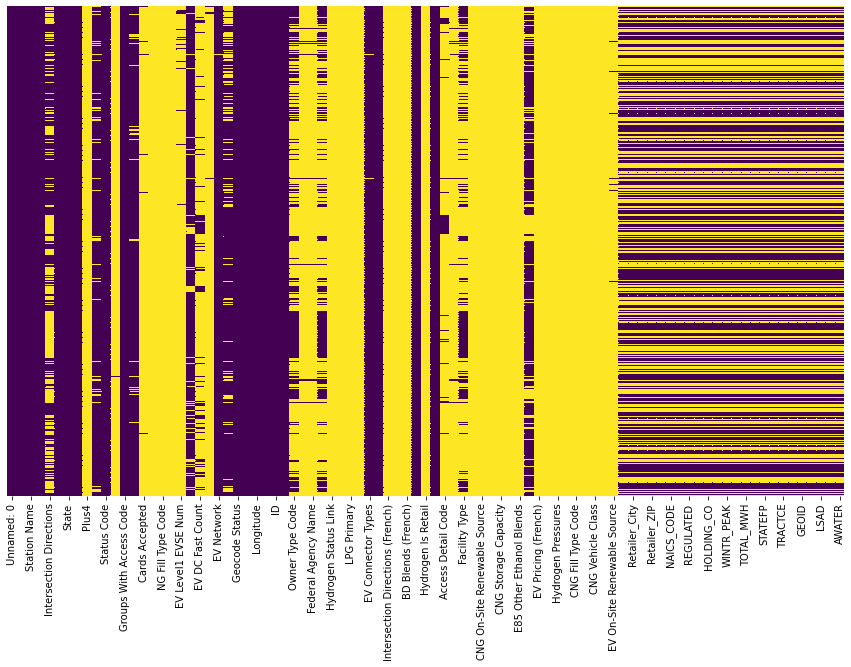

In [114]:
# Heat map showing missing variables
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

As we can see our data has a lot of missing values which we cannot work with. We need to drop some columns.

In [115]:
clean_df = df.drop(["BD Blends","NG PSI", "LPG Primary", "E85 Blender Pump","Intersection Directions (French)",
         "Access Days Time (French)","BD Blends (French)", "Hydrogen Is Retail","CNG Dispenser Num", "NG Vehicle Class",
         "Hydrogen Status Link", "NG Fill Type Code", "Plus4", "CNG On-Site Renewable Source", "CNG Storage Capacity",
         "EV Pricing (French)", "CNG Fill Type Code", "CNG Vehicle Class", "LNG Vehicle Class", "LPG Nozzle Types",
                 "Hydrogen Pressures", "Hydrogen Standards", "CNG PSI", "EV On-Site Renewable Source", 
                 "LNG On-Site Renewable Source", "E85 Other Ethanol Blends", "CNG Total Compression Capacity",
                 "Federal Agency ID", "Federal Agency Name", "EV Other Info", "Expected Date", "Cards Accepted",
                 "Access Detail Code", "Federal Agency Code", "Unnamed: 0", "Station Phone", "CUSTOMERS", "Status Code", 
                 "STATEFP", "COUNTYFP", "TRACTCE", "AFFGEOID", "GEOID", "NAME", "LSAD", "AWATER", "NAICS_CODE", 
                 "NAICS_DESC", "REGULATED", "CNTRL_AREA", "SUMMR_PEAK", "WINTR_PEAK", "RETAIL_MWH", "TOTAL_MWH", 
                 "Fuel Type Code", "Intersection Directions", "State", "Access Days Time", "EV Network Web", 
                 "Groups With Access Code (French)", "Retailer_Name", "Retailer_City", "Retailer_State", "Retailer_ZIP",
                 "Updated At", "Owner Type Code", "Open Date", "EV Connector Types", "Country", "Geocode Status",
                 "EV Network", "Date Last Confirmed", "ID", 
                 
        ], axis = 1)

Now, let's take a look at the heatmap again showing missing data.

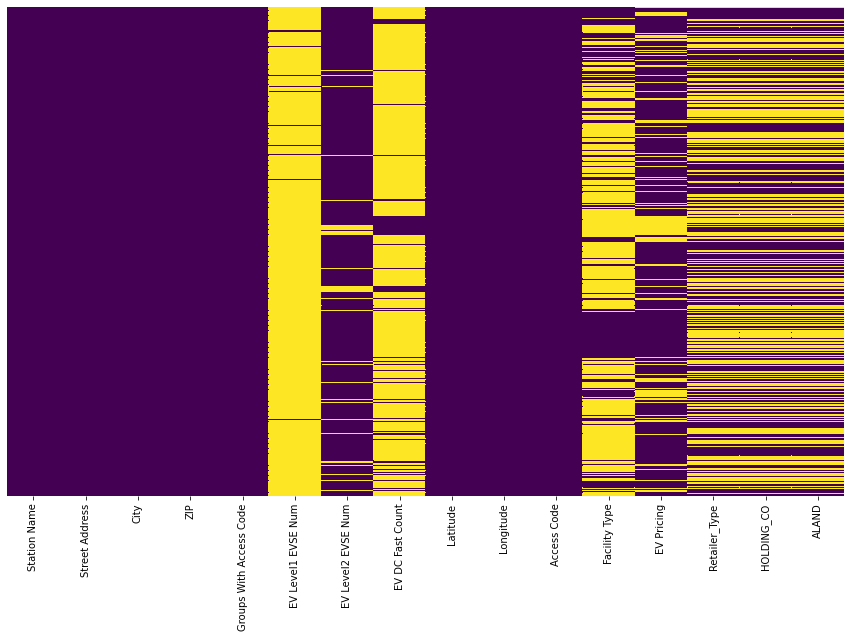

In [116]:
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(clean_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#plt.savefig("missingdata.png")

### Now, we view our new data

In [117]:
clean_df.head()

,Station Name,Street Address,City,ZIP,Groups With Access Code,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,Access Code,Facility Type,EV Pricing,Retailer_Type,HOLDING_CO,ALAND
0,City of Sacramento - Capitol Parking Garage,1015 L St,Sacramento,95814,Public,2.0,NaN,NaN,38.578380,-121.492600,public,PAY_GARAGE,NaN,NaN,NaN,NaN
1,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,91352,Private,NaN,15.0,NaN,34.248319,-118.387971,private,UTILITY,NaN,MUNICIPAL,GLENDALE WATER & POWER,7457722.0
2,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,Rosemead,91770,Private,22.0,22.0,NaN,34.050745,-118.081014,private,UTILITY,NaN,INVESTOR OWNED,SOUTHERN CALIFORNIA EDISON,3339724.0
3,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,90015,Public,NaN,12.0,NaN,34.040570,-118.268762,public,PARKING_GARAGE,NaN,NaN,NaN,NaN
4,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,90012,Private,NaN,239.0,NaN,34.058476,-118.248190,private,UTILITY,NaN,MUNICIPAL,GLENDALE WATER & POWER,862957.0


In [118]:
clean_df.columns

Index(['Station Name', 'Street Address', 'City', 'ZIP',
       'Groups With Access Code', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num',
       'EV DC Fast Count', 'Latitude', 'Longitude', 'Access Code',
       'Facility Type', 'EV Pricing', 'Retailer_Type', 'HOLDING_CO', 'ALAND'],
      dtype='object')

In [119]:
clean_df.describe()

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,ALAND
count,169.000000,5947.000000,941.000000,6559.000000,6559.000000,3.551000e+03
mean,3.260355,3.922818,4.094580,35.684679,-119.764800,6.263720e+07
std,5.955462,7.150108,5.306016,2.151101,2.575392,6.095967e+08
min,1.000000,1.000000,1.000000,1.000000,-124.265826,6.229400e+04
25%,1.000000,2.000000,2.000000,33.931487,-121.969853,1.464598e+06
50%,1.000000,2.000000,2.000000,34.413628,-119.023900,3.006864e+06
75%,3.000000,4.000000,4.000000,37.691932,-117.995671,8.620730e+06
max,51.000000,239.000000,40.000000,41.956710,1.000000,1.800491e+10


From our trimmed dataset, we see that facility type have the most missing data. Here we see which facility type was the most impacted. Now we see which stations were mostly affected.

In [120]:
#missing values in facility type
clean_df[clean_df["Facility Type"].isnull()][["Station Name", "Facility Type", "Groups With Access Code"]].head(50)

,Station Name,Facility Type,Groups With Access Code
8,CITYOFSANTAROSA,NaN,Public
33,CNTYOFRIVERSIDE,NaN,Public
67,CITY OF SB EV2,NaN,Public
112,SAN JOSE,NaN,Public
133,CCSF SFMTA,NaN,Public
134,SAN JOSE,NaN,Public
135,PUBLIC STATIONS,NaN,Public
142,SOUTHCOASTPLAZA,NaN,Public
143,MARTINEZ CA,NaN,Public
152,PARK TOWER,NaN,Public


### Stations with multiple chargers



In [121]:
clean_df[["Station Name", "City",  "EV Level2 EVSE Num", "EV DC Fast Count"]].dropna().head(20)

,Station Name,City,EV Level2 EVSE Num,EV DC Fast Count
11,LADWP - EV Service Center,Los Angeles,30.0,1.0
119,LADWP - Valley Center Admin Lot,Van Nuys,56.0,1.0
142,SOUTHCOASTPLAZA,Costa Mesa,10.0,6.0
151,City of Santa Monica - Civic Parking Garage,Santa Monica,14.0,1.0
155,CAL STATE LA,Los Angeles,15.0,12.0
163,Nissan of Bakersfield,Bakersfield,1.0,1.0
166,Palm Springs Nissan,Cathedral City,1.0,1.0
169,Puente Hills Nissan,City of Industry,2.0,1.0
171,Nissan of Serramonte,Colma,1.0,1.0
173,Larry H Miller Nissan,Corona,2.0,1.0


Next, we look at the top cities with highest EV charger count with different charging speed. 

In [122]:
# Top 10 Cities with EV level 3
clean_df[clean_df["EV DC Fast Count"].notnull()].groupby("City").sum()["EV DC Fast Count"].sort_values(ascending = False).head(10)

City
San Diego        144.0
San Jose         119.0
Los Angeles       99.0
Pasadena          92.0
Sacramento        92.0
Menlo Park        85.0
Baker             52.0
Thousand Oaks     51.0
Anaheim           46.0
Milpitas          45.0
Name: EV DC Fast Count, dtype: float64

In [123]:
# Top 10 Cities with EV level 2
clean_df[clean_df["EV Level2 EVSE Num"].notnull()].groupby("City").sum()["EV Level2 EVSE Num"].sort_values(ascending = False).head(10)

City
Los Angeles      2909.0
San Diego        1457.0
San Francisco     890.0
San Jose          844.0
Irvine            737.0
Santa Clara       607.0
Sacramento        536.0
Menlo Park        459.0
Anaheim           369.0
Redwood City      315.0
Name: EV Level2 EVSE Num, dtype: float64

In [124]:
# Top 10 Cities with EV level 1
clean_df[clean_df["EV Level1 EVSE Num"].notnull()].groupby("City").sum()["EV Level1 EVSE Num"].sort_values(ascending = False).head(10)

City
Sacramento       96.0
San Francisco    62.0
Rosemead         57.0
Los Angeles      56.0
Santa Rosa       24.0
Sunnyvale        19.0
Menlo Park       17.0
Oakland          15.0
Berkeley         14.0
Davis            11.0
Name: EV Level1 EVSE Num, dtype: float64

Looks interesting, Los Angeles and San Diego has the highest number of chargers in the state of California.



Next, we look at correlation map of the three EV infrastructural design. This tells us the extent of correlation between the three different designs.

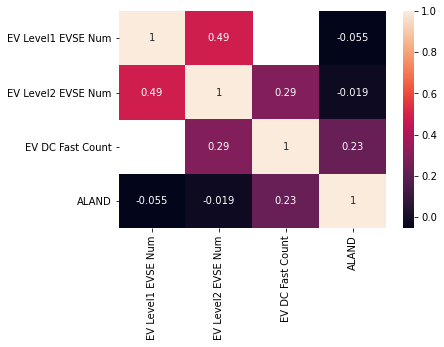

In [125]:
sns.heatmap(clean_df.drop(["Latitude", "Longitude"], axis = 1).corr(), annot = True)

# Location, Facility Type and Distribution  of EV Chargers

First, We explore the Facility Type, to see if it has impact on the distribution of the EV chargers. 

In [126]:
#facilities with DC fast chargers
clean_df.groupby("Facility Type")[["EV DC Fast Count", "Facility Type"]].sum().sort_values(by = "EV DC Fast Count", ascending = False).head(10)

,EV DC Fast Count
Facility Type,
SHOPPING_CENTER,337.0
SHOPPING_MALL,147.0
CAR_DEALER,62.0
HOTEL,49.0
MUNI_GOV,35.0
PARKING_GARAGE,28.0
PAY_LOT,25.0
UTILITY,17.0
STADIUM,16.0


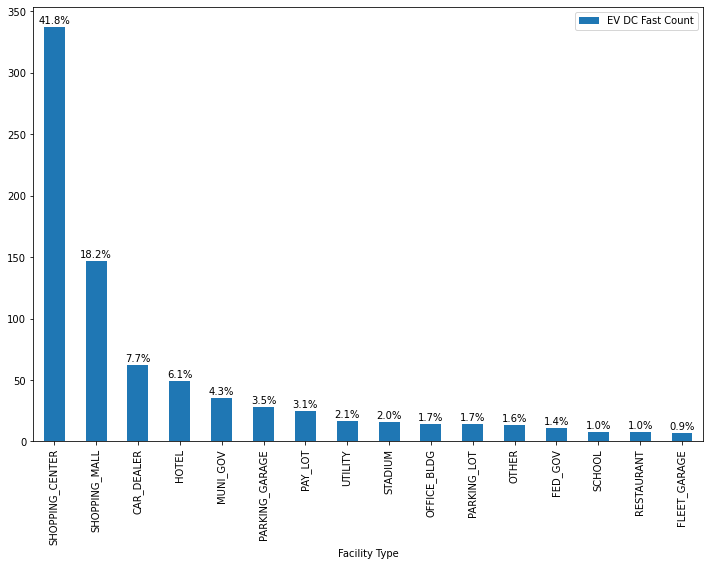

In [127]:

l3 = clean_df.groupby("Facility Type")[["EV DC Fast Count", "Facility Type"]].sum().sort_values(by = "EV DC Fast Count", ascending = False)#.hist(x = )
l3.reset_index(inplace = True)

total = sum(l3["EV DC Fast Count"])
ax = l3.loc[:15].plot.bar(x = "Facility Type", y = "EV DC Fast Count", figsize = (12,8))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height*100)/total),
            ha="center")





In [128]:
#Facilities with EV Level 2 chargers
clean_df.groupby("Facility Type")[["EV Level2 EVSE Num", "Facility Type"]].sum().sort_values(by = "EV Level2 EVSE Num", ascending = False).head(10)

,EV Level2 EVSE Num
Facility Type,
HOTEL,1380.0
OFFICE_BLDG,1070.0
MUNI_GOV,812.0
UTILITY,799.0
CAR_DEALER,429.0
PARKING_LOT,353.0
HOSPITAL,348.0
PARKING_GARAGE,344.0
BREWERY_DISTILLERY_WINERY,282.0


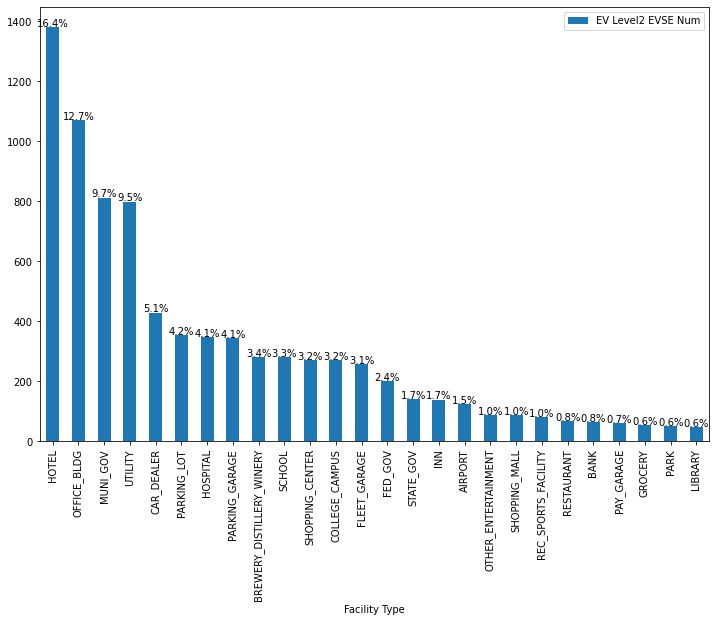

In [129]:
l2 = clean_df.groupby("Facility Type")[["EV Level2 EVSE Num", "Facility Type"]].sum().sort_values(by = "EV Level2 EVSE Num", ascending = False).reset_index()#.head(10)

l2.reset_index(inplace = True)
total = sum(l2["EV Level2 EVSE Num"])
ax = l2.loc[:25].plot.bar(x = "Facility Type", y = "EV Level2 EVSE Num", figsize = (12,8))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height*100)/total),
            ha="center")


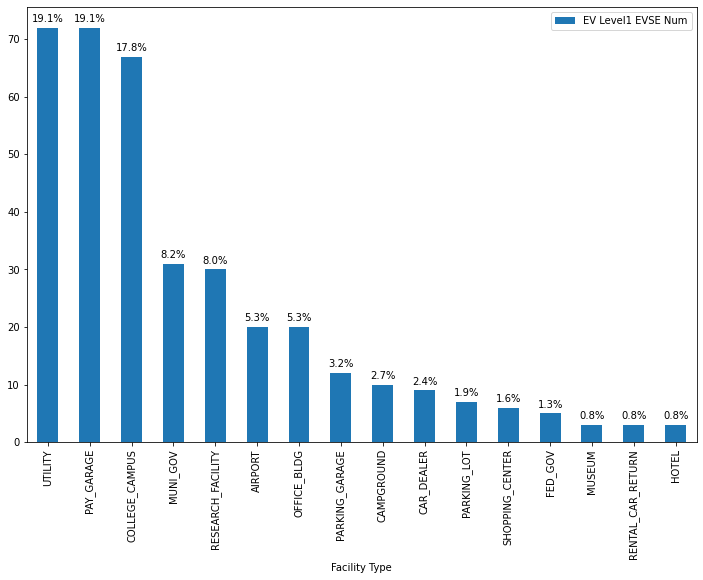

In [130]:
l1 = clean_df.groupby("Facility Type")[["EV Level1 EVSE Num", "Facility Type"]].sum().sort_values(by = "EV Level1 EVSE Num", ascending = False).reset_index()#.head(10)

l1.reset_index(inplace = True)

total = sum(l1["EV Level1 EVSE Num"])
ax = l1.loc[:15].plot.bar(x = "Facility Type", y = "EV Level1 EVSE Num", figsize = (12,8))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:.1f}%'.format((height*100)/total),
            ha="center")

[Text(0, 0, 'PAY_GARAGE'),
 Text(0, 0, 'UTILITY'),
 Text(0, 0, 'MUNI_GOV'),
 Text(0, 0, 'OFFICE_BLDG'),
 Text(0, 0, 'PARKING_GARAGE'),
 Text(0, 0, 'CAR_DEALER'),
 Text(0, 0, 'PARKING_LOT'),
 Text(0, 0, 'SHOPPING_CENTER'),
 Text(0, 0, 'SCHOOL'),
 Text(0, 0, 'RESTAURANT'),
 Text(0, 0, 'PAY_LOT'),
 Text(0, 0, 'SHOPPING_MALL')]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


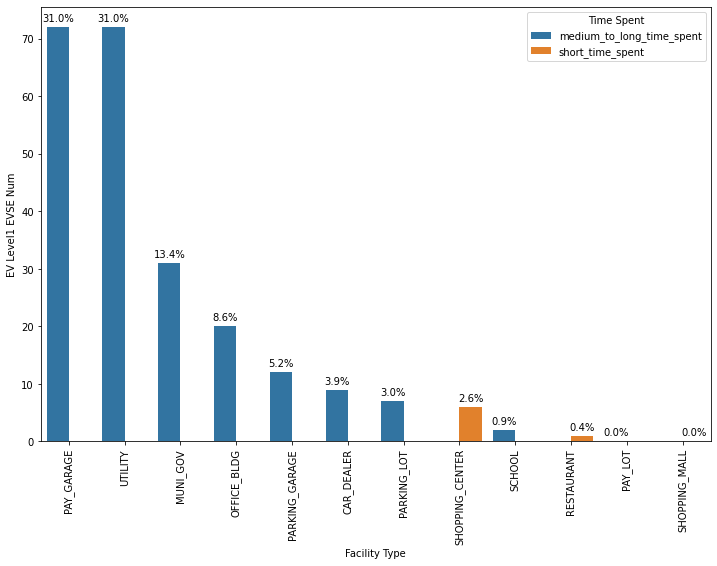

In [131]:
#percentage share of facilities with EV Level 1 chargers according to time spent
lev1 = model_df.groupby(["Facility Type", "Time Spent"])[["EV Level1 EVSE Num", "Facility Type"]].sum().sort_values(by = "EV Level1 EVSE Num", ascending = False).reset_index()#.head(10)

plt.figure(figsize = (12,8))
total = sum(lev1["EV Level1 EVSE Num"])
ax = sns.barplot(x = "Facility Type", y = "EV Level1 EVSE Num", data = lev1, hue = "Time Spent")



for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:.1f}%'.format((height*100)/total),
            ha="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

[Text(0, 0, 'OFFICE_BLDG'),
 Text(0, 0, 'MUNI_GOV'),
 Text(0, 0, 'UTILITY'),
 Text(0, 0, 'CAR_DEALER'),
 Text(0, 0, 'PARKING_LOT'),
 Text(0, 0, 'PARKING_GARAGE'),
 Text(0, 0, 'SCHOOL'),
 Text(0, 0, 'SHOPPING_CENTER'),
 Text(0, 0, 'SHOPPING_MALL'),
 Text(0, 0, 'RESTAURANT'),
 Text(0, 0, 'PAY_GARAGE'),
 Text(0, 0, 'PAY_LOT')]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


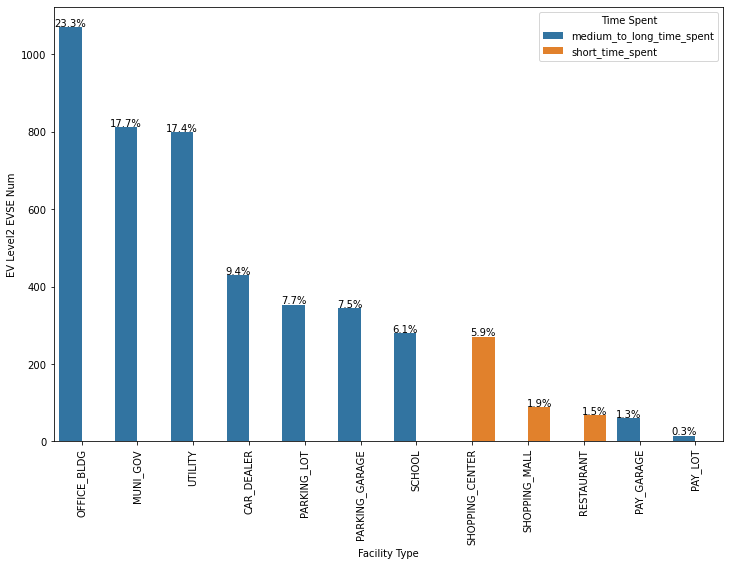

In [132]:
#percentage share of facilities with EV Level 2 chargers according to time spent
lev2 = model_df.groupby(["Facility Type", "Time Spent"])[["EV Level2 EVSE Num", "Facility Type"]].sum().sort_values(by = "EV Level2 EVSE Num", ascending = False).reset_index()#.head(10)
plt.figure(figsize = (12,8))
total = sum(lev2["EV Level2 EVSE Num"])
ax = sns.barplot(x = "Facility Type", y = "EV Level2 EVSE Num", data = lev2, hue = "Time Spent")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height*100)/total),
            ha="center")

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

[Text(0, 0, 'SHOPPING_CENTER'),
 Text(0, 0, 'SHOPPING_MALL'),
 Text(0, 0, 'CAR_DEALER'),
 Text(0, 0, 'MUNI_GOV'),
 Text(0, 0, 'PARKING_GARAGE'),
 Text(0, 0, 'PAY_LOT'),
 Text(0, 0, 'UTILITY'),
 Text(0, 0, 'OFFICE_BLDG'),
 Text(0, 0, 'PARKING_LOT'),
 Text(0, 0, 'RESTAURANT'),
 Text(0, 0, 'SCHOOL'),
 Text(0, 0, 'PAY_GARAGE')]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


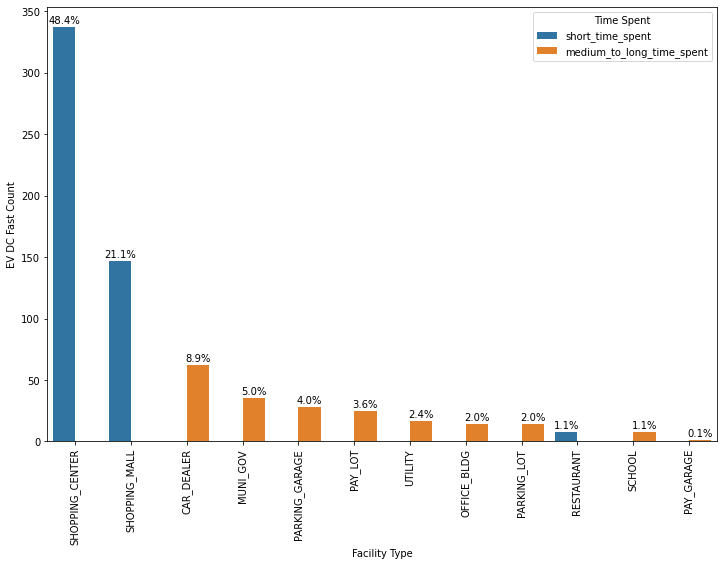

In [133]:
#percentage share of facilities with DC Fast chargers according to time spent
lev3 = model_df.groupby(["Facility Type", "Time Spent"])[["EV DC Fast Count", "Facility Type"]].sum().sort_values(by = "EV DC Fast Count", ascending = False).reset_index()#.head(10)

plt.figure(figsize = (12,8))

total = sum(lev3["EV DC Fast Count"])
ax = sns.barplot(x = "Facility Type", y = "EV DC Fast Count", data = lev3, hue = "Time Spent")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height*100)/total),
            ha="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [134]:
melt_df

,Total EV Charging Stations,Charge,Facility Type,Design
0,2.0,NaN,PAY_GARAGE,Level1
2,22.0,NaN,UTILITY,Level1
40,1.0,Free,HOTEL,Level1
61,12.0,Free,PARKING_GARAGE,Level1
67,2.0,Paid,NaN,Level1
...,...,...,...,...
6544,40.0,Paid,NaN,DCFast
6545,8.0,Paid,NaN,DCFast
6546,4.0,Paid,NaN,DCFast
6547,4.0,NaN,NaN,DCFast


We can see clearly from the count plot that Facility type has an influence on EV charging speed.   

Next, we look at the distribution of the chargers in the state of California.

First, we need to convert our dataframe into geo dataframe in order to visualize it on a map.

In [135]:
# Get shape file for the state of California
cali_shp = gpd.read_file("bound.shp")             # Import shape files for the state of California
cali_shp = cali_shp.to_crs(epsg=4326)                # Set CRS for the shape file.

In [136]:
#Let's create a function to convert the longitude and latitude columns into Geometry points
def geo(df):
    p = []
    for i, j in zip(df["Longitude"], df["Latitude"]):
        p.append(Point([i, j]))

    return p

In [137]:
# Add the geometry points into our dataframe
clean_df["geometry"] = geo(clean_df)


In [138]:
# We can drop the Longitude and Latitude columns
clean_df.drop(["Longitude", "Latitude"], axis = 1, inplace = True)

In [139]:
# Now we can create a geo dataframe
geo_df = gpd.GeoDataFrame(clean_df, geometry = "geometry", crs = from_epsg(3857))

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [140]:
#df2 = df2.to_crs(df1.crs)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


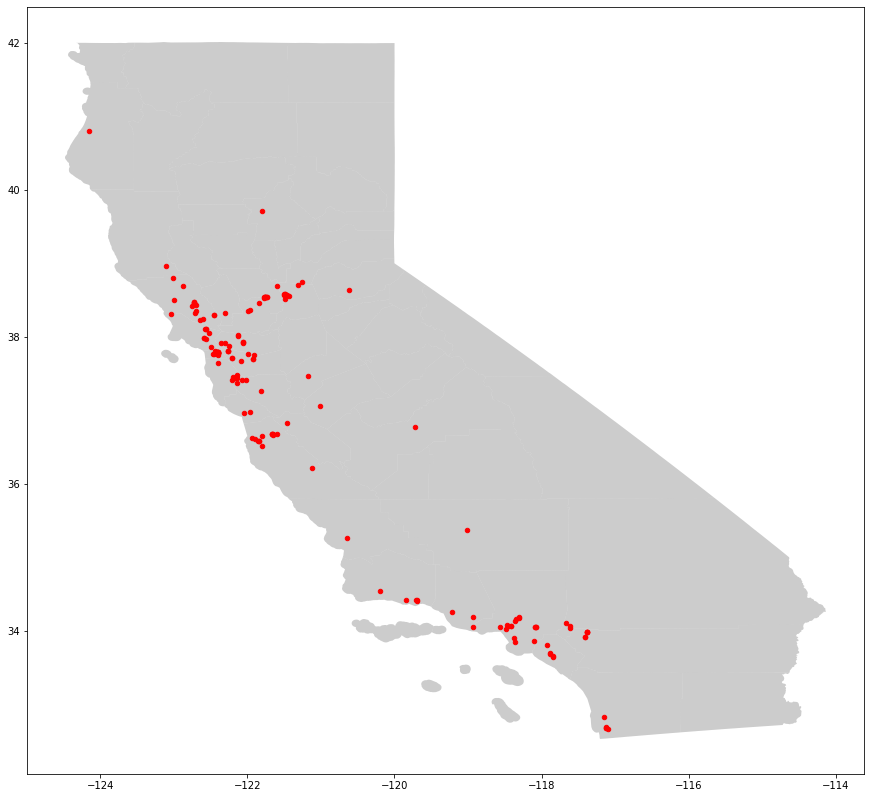

In [141]:
#EV level 1 chargers
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df["EV Level1 EVSE Num"].notnull()].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")



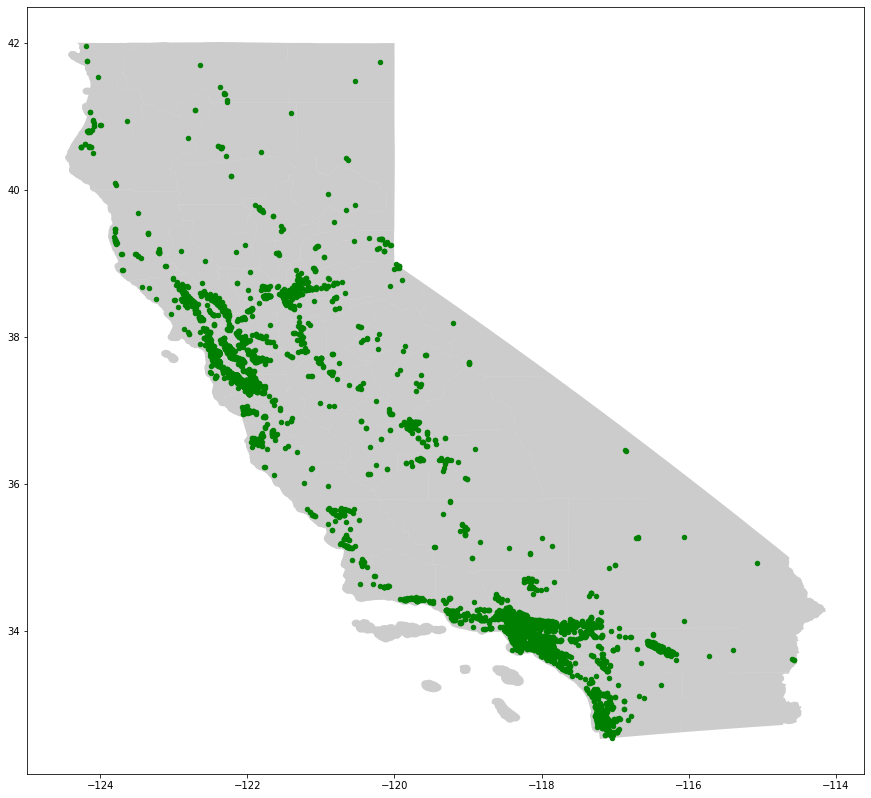

In [142]:
#EV level 2
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100)].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")


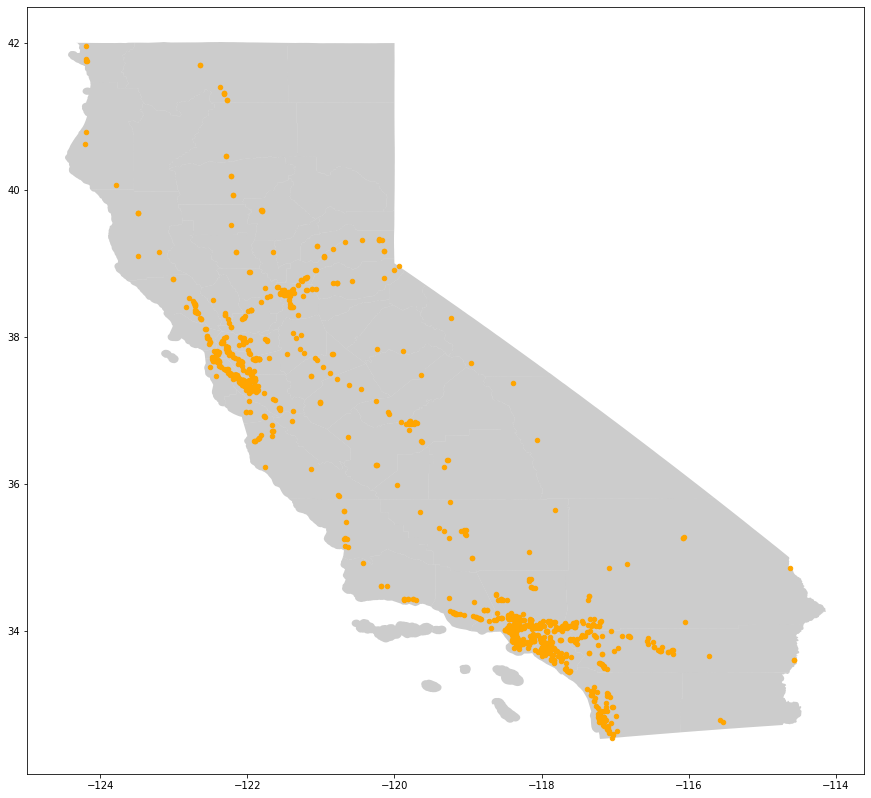

In [143]:
#EV DC fast
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "grey")

geo_df[geo_df["EV DC Fast Count"].notnull()].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")


C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


Text(0.5, 1.0, 'EV Charging Stations in California')

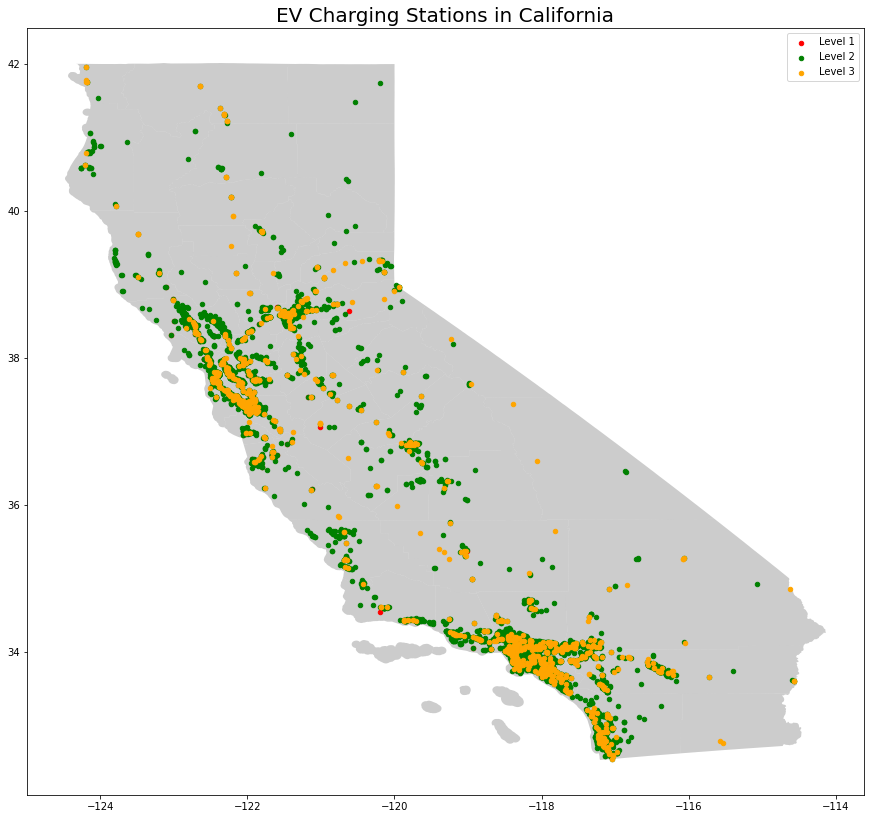

In [144]:
#All EV charging stations
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df["EV Level1 EVSE Num"].notnull()].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")


geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100)].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")
geo_df[geo_df["EV DC Fast Count"].notnull()].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")


plt.legend()
plt.title("EV Charging Stations in California", fontsize = 20)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


Text(0.5, 1.0, 'EV Charging Stations Located in Hotels, California')

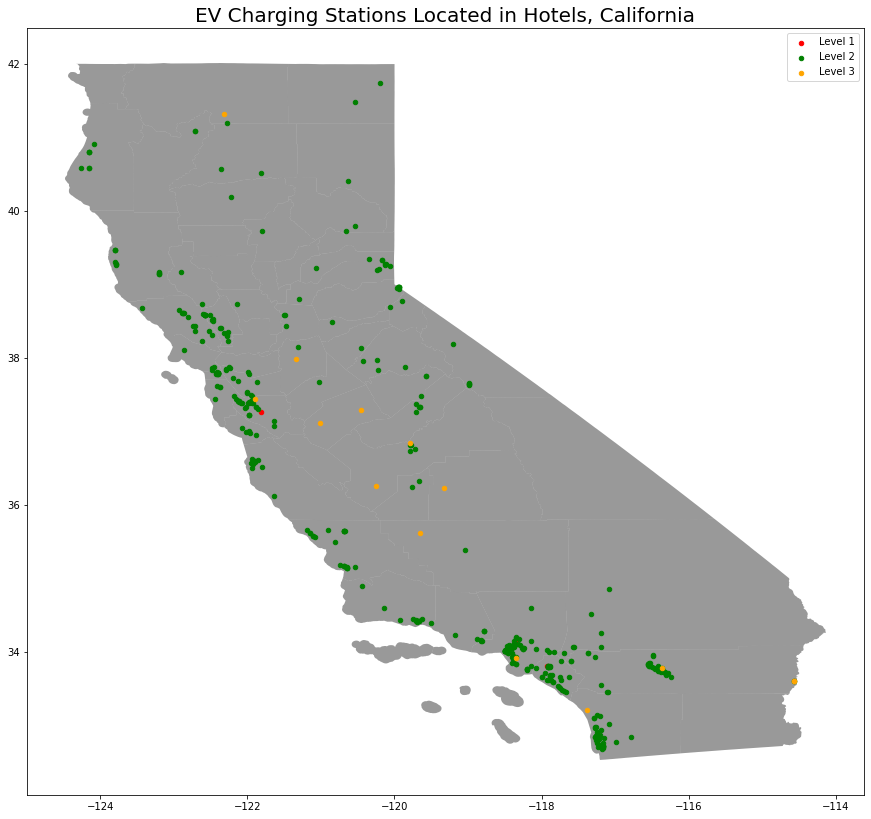

In [145]:
#Analysis of different facility type to distribution of EV charging design

#EV all charging stations for hotels
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "black")
geo_df[(geo_df["EV Level1 EVSE Num"].notnull()) & (geo_df["Facility Type"] == "HOTEL")].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")


geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100) & (geo_df["Facility Type"] == "HOTEL")].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")
geo_df[(geo_df["Facility Type"] == "HOTEL") & (geo_df["EV DC Fast Count"].notnull())].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")


plt.legend()
plt.title("EV Charging Stations Located in Hotels, California", fontsize = 20)
#plt.savefig("EVchanging.png", dpi = 300)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Text(0.5, 1.0, 'EV Charging Stations Located in Shopping Malls, California')

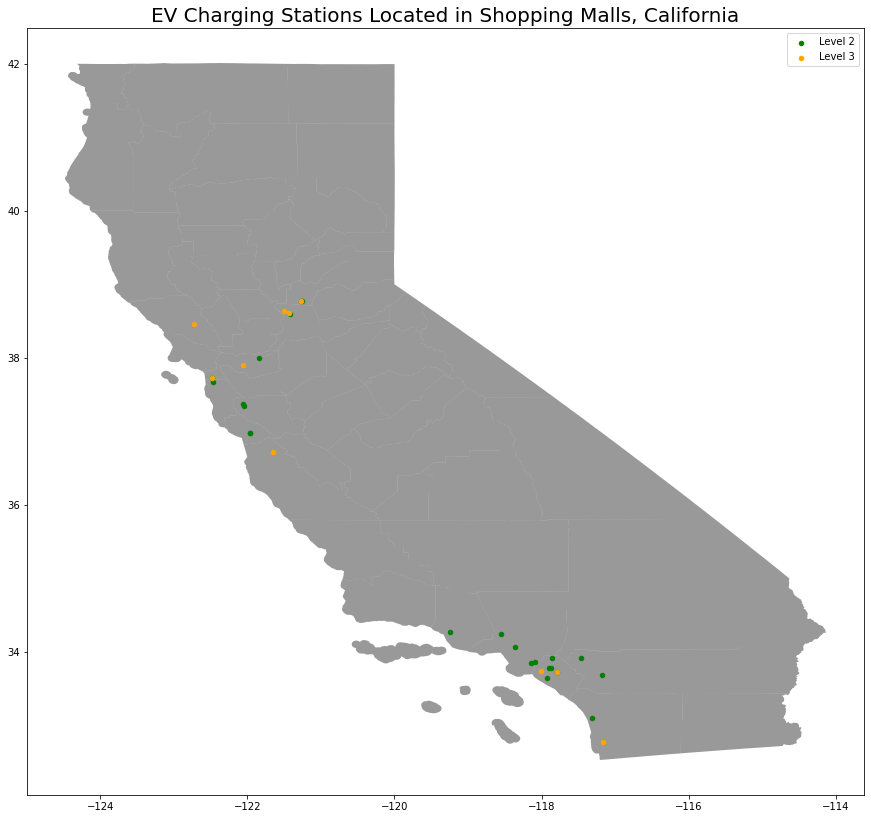

In [146]:
#EV charging stations located in shopping malls
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "black")
geo_df[(geo_df["EV Level1 EVSE Num"].notnull()) & (geo_df["Facility Type"] == "SHOPPING_MALL")].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")


geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100) & (geo_df["Facility Type"] == "SHOPPING_MALL")].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")
geo_df[(geo_df["Facility Type"] == "SHOPPING_MALL") & (geo_df["EV DC Fast Count"].notnull())].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")


plt.legend()
plt.title("EV Charging Stations Located in Shopping Malls, California", fontsize = 20)
#plt.savefig("EVchanging.png", dpi = 300)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


Text(0.5, 1.0, 'EV Charging Stations Located in Shopping Centers, California')

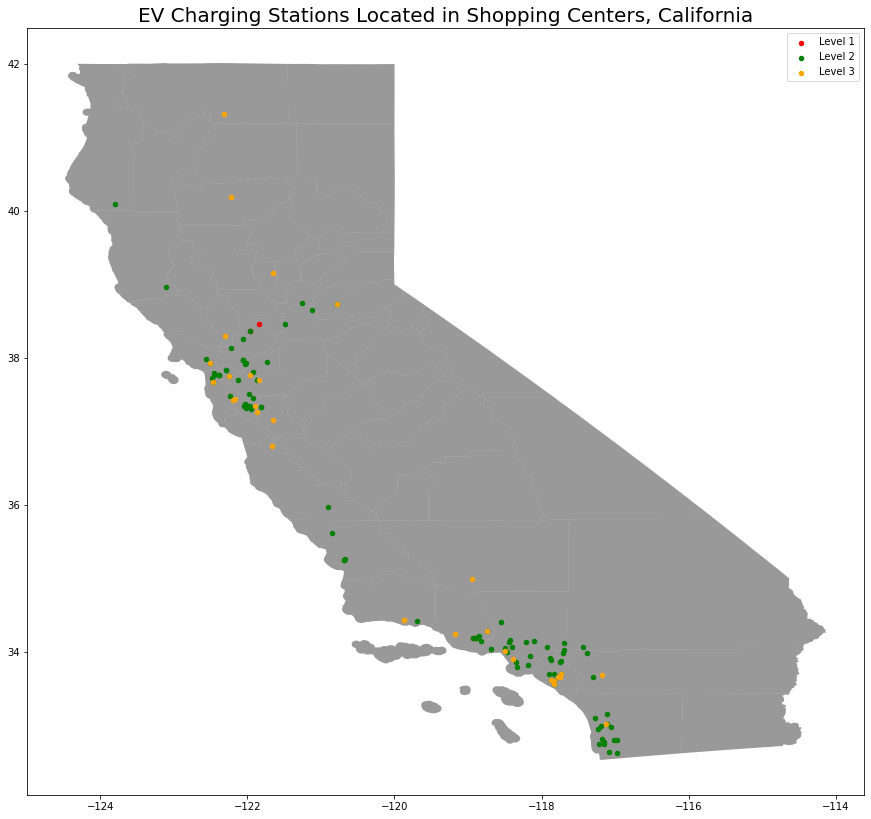

In [147]:
#EV charging stations located in shopping centres
fig, ax = plt.subplots(figsize = (15, 15))

cali_shp.plot(ax = ax, alpha = 0.4, color = "black")
geo_df[(geo_df["EV Level1 EVSE Num"].notnull()) & (geo_df["Facility Type"] == "SHOPPING_CENTER")].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")


geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100) & (geo_df["Facility Type"] == "SHOPPING_CENTER")].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")
geo_df[(geo_df["Facility Type"] == "SHOPPING_CENTER") & (geo_df["EV DC Fast Count"].notnull())].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")


plt.legend()
plt.title("EV Charging Stations Located in Shopping Centers, California", fontsize = 20)
#plt.savefig("EVchanging.png", dpi = 300)

Talk about the distribution of the chargers in the map, facility type plays an important role in the location and the design of the EV chargers. EV level 1 chargers are mostly located in facilities where users spend long amount of time, example example college campus. EV level 2 chargers are located in facilities where users spend medium to long time such as hotels. On the contrary, EV DC fast chargers are mostly installed in facilities where users spend a short period of time, for example Shopping centers, shopping malls and highways

# Pricing Analysis

Here we analyse paid vs free services for all EV chargers in California, and do same for the three different designs.

In [37]:
#we create a function for free vs paid services

def price(p):
    x = None
    if p == "Free":
        x = "Free"
    elif type(p) == str:
        x = "Paid"
    else:
        x = p
    return x

clean_df["Charge"] = clean_df["EV Pricing"].apply(price)

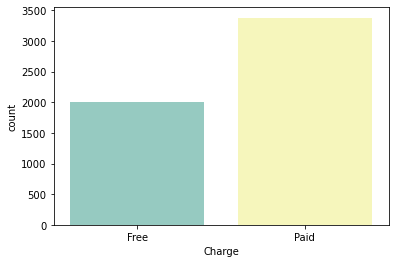

In [38]:
#free vs paid all charging staions
sns.countplot(clean_df["Charge"], palette="Set3")

In [39]:
#total free chargers
(clean_df["Charge"] == "Free").sum()

1996

In [40]:
#total paid chargers
(clean_df["Charge"] == "Paid").sum()

3379

In [41]:
#percentage of free chargers
percentage_of_free = (1996/5375) * (100)
percentage_of_free



37.13488372093023

In [42]:
#percentage of paid chargers
percentage_of_Paid = (3379/5375) * (100)
percentage_of_Paid

62.86511627906977

Text(0.5, 1.0, 'Facility Type Count for EV Level 1')

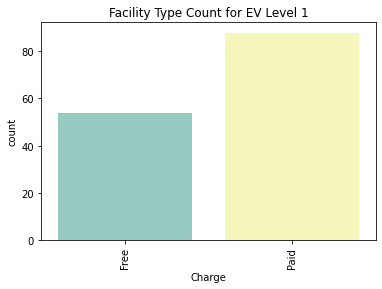

In [43]:
#free vs paid all EV level 1 chargers
ax = sns.countplot(x = "Charge", data = clean_df[clean_df["EV Level1 EVSE Num"].notnull()], palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title("Facility Type Count for EV Level 1")

In [44]:
#total free chargers for EV level 1
(clean_df[clean_df["EV Level1 EVSE Num"].notnull()]["Charge"] == "Free").sum()

54

In [45]:
#total paid chargers for EV level 1
(clean_df[clean_df["EV Level1 EVSE Num"].notnull()]["Charge"] == "Paid").sum()

88

Text(0.5, 1.0, 'Facility Type Count for EV Level 2')

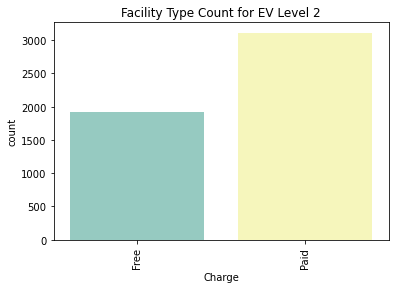

In [46]:
#Free vs paid for EV level 2
ax = sns.countplot(x = "Charge", data = clean_df[clean_df["EV Level2 EVSE Num"].notnull()],palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title("Facility Type Count for EV Level 2")

In [47]:
#total free chargers for EV level 2
(clean_df[clean_df["EV Level2 EVSE Num"].notnull()]["Charge"] == "Free").sum()

1918

In [48]:
#total free chargers for EV level 2
(clean_df[clean_df["EV Level2 EVSE Num"].notnull()]["Charge"] == "Paid").sum()

3111

Text(0.5, 1.0, 'Facility Type Count for DC Fast Charge')

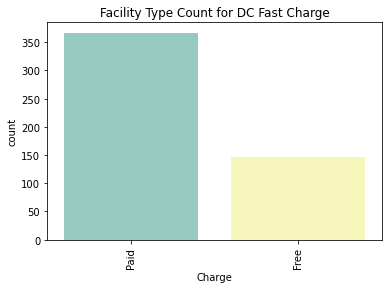

In [49]:
#free vs aid for DC fast charge
ax = sns.countplot(x = "Charge", data = clean_df[clean_df["EV DC Fast Count"].notnull()], palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title("Facility Type Count for DC Fast Charge")

In [50]:
#total free chargers for Dc fast chargers
(geo_df[geo_df["EV DC Fast Count"].notnull()]["Charge"] == "Free").sum()

147

In [51]:
#total paid chargers for DC fast charge
(geo_df[geo_df["EV DC Fast Count"].notnull()]["Charge"] == "Paid").sum()

367

In [52]:
#incorporating all charging design
df_melt2 = clean_df[clean_df["EV Level1 EVSE Num"].notnull()][["EV Level1 EVSE Num", "Charge", "Facility Type"]]
df_melt2.rename({"EV Level1 EVSE Num": "Total EV Charging Stations"}, axis = 1, inplace = True)
df_melt2["Design"] = "Level1"

In [53]:
df_melt1 = clean_df[clean_df["EV Level2 EVSE Num"].notnull()][["EV Level2 EVSE Num", "Charge", "Facility Type"]]
df_melt1.rename({"EV Level2 EVSE Num": "Total EV Charging Stations"}, axis = 1, inplace = True)
df_melt1["Design"] = "Level2"

In [54]:
df_melt = clean_df[clean_df["EV DC Fast Count"].notnull()][["EV DC Fast Count", "Charge", "Facility Type"]]
df_melt.rename({"EV DC Fast Count": "Total EV Charging Stations"}, axis = 1, inplace = True)
df_melt["Design"] = "DCFast"

In [55]:
melt_df = pd.concat([df_melt2, df_melt1, df_melt], axis = 0)

In [56]:
melt_df

,Total EV Charging Stations,Charge,Facility Type,Design
0,2.0,NaN,PAY_GARAGE,Level1
2,22.0,NaN,UTILITY,Level1
40,1.0,Free,HOTEL,Level1
61,12.0,Free,PARKING_GARAGE,Level1
67,2.0,Paid,NaN,Level1
...,...,...,...,...
6544,40.0,Paid,NaN,DCFast
6545,8.0,Paid,NaN,DCFast
6546,4.0,Paid,NaN,DCFast
6547,4.0,NaN,NaN,DCFast


<Figure size 864x576 with 0 Axes>

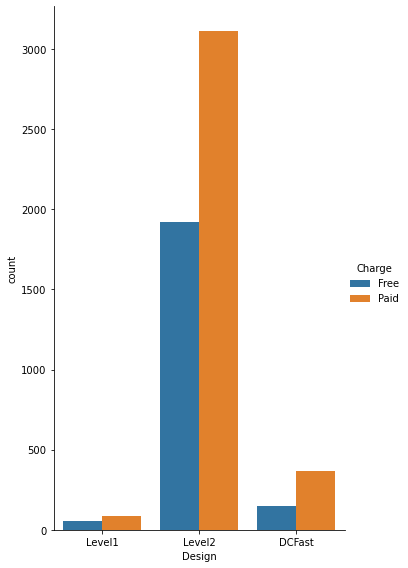

In [57]:
#Free vs Paid for Charging Designs together
plt.figure(figsize = (12,8))
ax = sns.catplot(x="Design", hue="Charge", 
                data=melt_df, kind="count",
                height=8, aspect=.6)





In [58]:
#sns.barplot(x = "Facility Type", y = "EV", data = melt_df)
melt_df.groupby("Facility Type").apply(lambda x: x.sort_values(by = "Total EV Charging Stations", ascending = False))#[["EV"]]#.sum()#.sort_values(by = "EV", ascending = False).reset_index()

Total EV Charging Stations Charge Facility Type  Design
Facility Type                                                              
AIRPORT       2310                        28.0   Free       AIRPORT  Level2
              27                          20.0   Free       AIRPORT  Level2
              111                         20.0   Free       AIRPORT  Level2
              5534                        12.0   Free       AIRPORT  Level1
              4552                        12.0   Free       AIRPORT  Level2
...                                        ...    ...           ...     ...
UTILITY       6490                         1.0    NaN       UTILITY  Level2
              6491                         1.0    NaN       UTILITY  Level2
              6492                         1.0    NaN       UTILITY  Level2
              6493                         1.0    NaN       UTILITY  Level2
              6482                         1.0   Free       UTILITY  DCFast

[2396 rows x 4 columns]

In [59]:
#Distinguishing Different Designs and Location
fac_df = melt_df.groupby(["Facility Type", "Design"])[["Total EV Charging Stations"]].sum().sort_values(by = "Total EV Charging Stations", ascending = False).reset_index()#.head(49)

In [60]:
fac_df.set_index("Facility Type", inplace = True)

In [61]:
fac_final = fac_df.loc[["HOTEL", "OFFICE_BLDG", "MUNI_GOV", "UTILITY", "CAR_DEALER", "SHOPPING_CENTER", "SHOPPING_MALL", "COLLEGE_CAMPUS", "RESTAURANT"]]

In [62]:
fac_final.reset_index(inplace = True)

[Text(0, 0, 'HOTEL'),
 Text(0, 0, 'OFFICE_BLDG'),
 Text(0, 0, 'MUNI_GOV'),
 Text(0, 0, 'UTILITY'),
 Text(0, 0, 'CAR_DEALER'),
 Text(0, 0, 'SHOPPING_CENTER'),
 Text(0, 0, 'SHOPPING_MALL'),
 Text(0, 0, 'COLLEGE_CAMPUS'),
 Text(0, 0, 'RESTAURANT')]

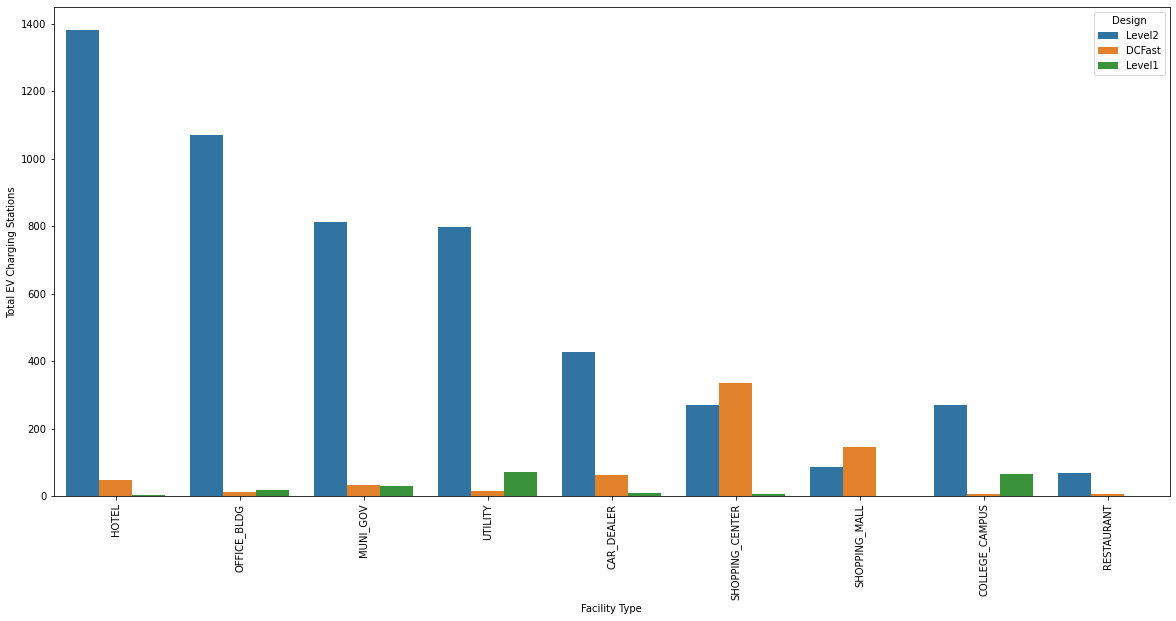

In [63]:
plt.figure(figsize = (20,9))
ax = sns.barplot(x = "Facility Type", y = "Total EV Charging Stations", data = fac_final, hue = "Design")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [ ]:
for b in melt_df["Type"].unique():
    

In [466]:
melt_df[:160]#[melt_df["Type"] == "Level1"]["EV"][:160]

,EV,Charge,Type
0,2.0,NaN,Level1
2,22.0,NaN,Level1
40,1.0,Free,Level1
61,12.0,Free,Level1
67,2.0,Paid,Level1
...,...,...,...
3460,2.0,NaN,Level1
3500,1.0,Free,Level1
3690,1.0,Free,Level1
3863,7.0,Paid,Level1


<Figure size 864x576 with 0 Axes>

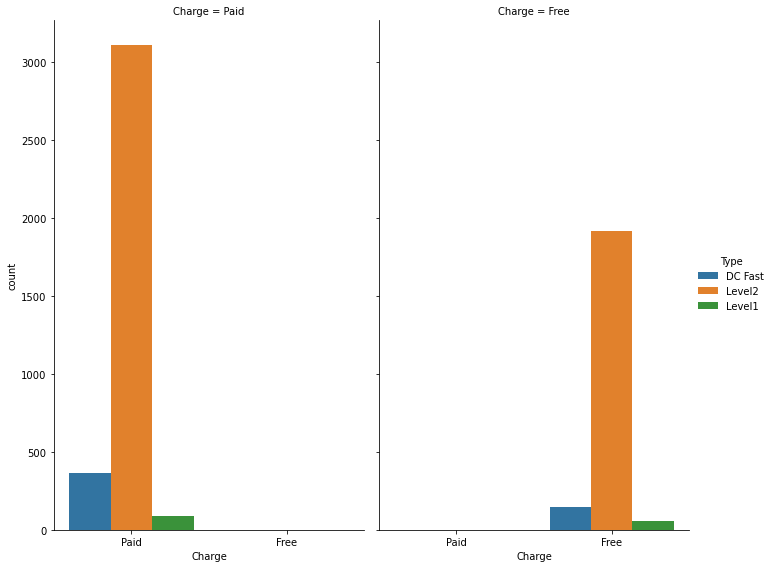

In [654]:
plt.figure(figsize = (12,8))
sns.catplot(x="Charge", hue="Type", col="Charge",
                data=melt_df, kind="count",
                height=8, aspect=.6)
#plt.yscale('log')

We can see from the barplots that there are more paid and free services, which is about 60% to 40% for both EV Level 1 and EV Level 2, bu for DC Fast chargers, its around 70% to 30% in favour of paid services. This may be because the charging speed is faster and it is usually expensive to install.

# Training a Linear Regression Model

Let's now begin to train our regression model! We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column. We will toss out the Address column because it only has text info that the linear regression model can't use.

# Model 1 - Population and Population Density

In this section, we analyse the relationship between population, population density and total number of Ev chargers. 

In [148]:
#import and create population dataframe
pop = pd.read_csv("population.csv")
pop.columns

Index(['fileid', 'stusab', 'chariter', 'cifsn', 'logrecno', 'p0020001',
       'p0020002', 'p0020003', 'p0020004', 'p0020005', 'p0020006', 'sumlev',
       'geocomp', 'zcta5', 'arealand', 'areawatr', 'name', 'funcstat',
       'pop100', 'hu100', 'intptlat', 'intptlon', 'lsadc'],
      dtype='object')

Since our dataframe contains the entire U.S data, we create a fucntion to extract California's population data using zip code. 

In [149]:
cali_pop = pop[(pop["zcta5"] >= 90000)]

# Reset index
cali_pop.reset_index(inplace = True)

cali_pop = cali_pop[["p0020001", "zcta5", "intptlat", "intptlon"]]
#cali_pop["zcta5"] = cali_pop["zcta5"].astype(str)
cali_pop

,p0020001,zcta5,intptlat,intptlon
0,57110,90001,33.974027,-118.249509
1,51223,90002,33.949099,-118.246737
2,66266,90003,33.964131,-118.272783
3,62180,90004,34.076198,-118.310723
4,37681,90005,34.059163,-118.306892
...,...,...,...,...
3105,87,99923,56.002315,-130.041026
3106,819,99925,55.550204,-132.945933
3107,1460,99926,55.138069,-131.470741
3108,94,99927,56.239062,-133.457924


In [150]:
# Let's create a function to convert the longitude and latitude columns into Geometry points
def geom(df):
    p = []
    for i, j in zip(df["intptlon"], df["intptlat"]):
        p.append(Point([i, j]))

    return p

# Assign geometry to new column called "geometry"
cali_pop["geometry"] = geom(cali_pop)

In [151]:
# Drop lon and lat columns
cali_pop.drop(["intptlat", "intptlon"], axis =1, inplace = True)

# Rename columns
cali_pop.rename({"p0020001": "pop", "zcta5": "ZIP"}, axis =1, inplace = True)

In [152]:
cali_pop

,pop,ZIP,geometry
0,57110,90001,POINT (-118.2495088 33.9740268)
1,51223,90002,POINT (-118.2467371 33.94909879999999)
2,66266,90003,POINT (-118.2727831 33.96413070000001)
3,62180,90004,POINT (-118.3107225 34.07619810000001)
4,37681,90005,POINT (-118.3068924 34.0591634)
...,...,...,...
3105,87,99923,POINT (-130.0410257 56.0023154)
3106,819,99925,POINT (-132.9459331 55.5502037)
3107,1460,99926,POINT (-131.4707407 55.1380691)
3108,94,99927,POINT (-133.4579239 56.2390623)


In [153]:
county = cali_shp[["geometry", "NAMELSAD", "ALAND"]]

In [154]:
# Convert pandas dataframe to Geo pandas dataframe
pop_geo = gpd.GeoDataFrame(cali_pop, geometry = "geometry", crs = from_epsg(3857)) 

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [155]:
# Join the population data with the .shp of california
cali_join = gpd.sjoin(county, pop_geo, how="inner", op='contains')

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:3857 +no_defs +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [156]:
# Use groupby and get the total population in each city
cali_city = cali_join.groupby("NAMELSAD").sum()[["pop", "ZIP"]].merge(county, on = "NAMELSAD")

# Convert to Geo pandas DataFrame
cali_city = gpd.GeoDataFrame(cali_city, geometry = "geometry", crs = from_epsg(3857))

# Drop zip column
cali_city.drop("ZIP", axis = 1, inplace = True)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


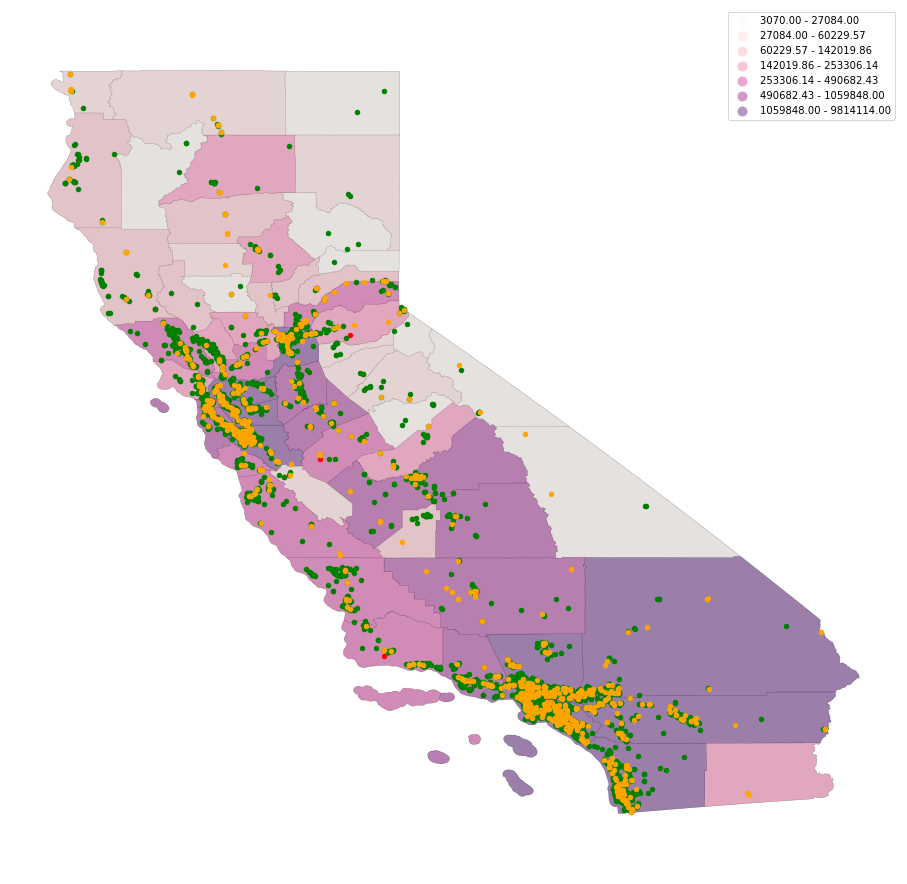

In [157]:
fig, ax = plt.subplots(figsize=(16,16))
cali_shp.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.4)
cali_city.plot(ax=ax,cmap = "RdPu",  alpha=0.4, scheme='quantiles', k=7, legend = True, column = "pop")
geo_df[geo_df["EV Level1 EVSE Num"].notnull()].plot(ax = ax, column = "EV Level1 EVSE Num", markersize = 20, color = "red", marker = "o", label = "Level 1")
geo_df[(geo_df["EV Level2 EVSE Num"].notnull()) & (geo_df["geometry"].x < -100)].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Level 2")
geo_df[geo_df["EV DC Fast Count"].notnull()].plot(ax = ax, markersize = 20, color = "orange", marker = "o", label = "Level 3")

ax.axis("off")
plt.axis("equal")
plt.savefig("pop.png", dpi = 300)
plt.show()

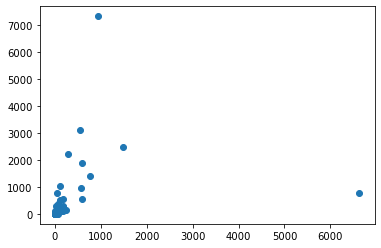

In [346]:
plt.scatter(x = "Density", y = "Total EV", data = pop_density)
plt.show()
#the plot shows presense of outliers

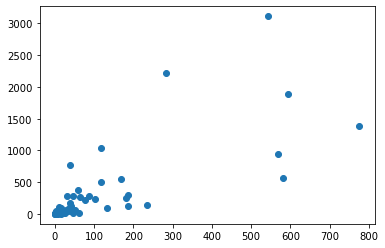

In [347]:
#dropping the outliers
plt.scatter(x = "Density", y = "Total EV", data = pop_density.drop([pop_density.index[37], pop_density.index[18], pop_density.index[29]]))
plt.show()



In [210]:
pop_density = cali_city.merge(ev, on = "NAMELSAD")

In [211]:
pop_density["Density"] = pop_density["pop"]/(pop_density["ALAND"]/1000000)

In [212]:
pop_density["EV_per_pop"] = pop_density["pop"]/(pop_density["Total EV"])

In [213]:
pop_density.drop("EV_per_pop", axis = 1, inplace = True)

In [214]:
#total EV chargers
pop_density["Total EV"].sum()

27724.0

In [215]:
#total population
pop_density["pop"].sum()


37249831

In [216]:
pop_regression = pop_density.drop([pop_density.index[37], pop_density.index[18], pop_density.index[29]])

In [217]:
#Population regression
x = pop_regression[[
       "Density"]]

y = pop_regression['Total EV']

In [218]:
# For our model we would split level1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [219]:
# Now we fit our model using linear regression
from sklearn.linear_model import LinearRegression
mod = LinearRegression()# Let's have a look at our model coefficient and intercept

mod.fit(x, y)

LinearRegression()

In [220]:
x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               Total EV   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     67.31
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           5.29e-11
Time:                        21:47:48   Log-Likelihood:                -406.33
No. Observations:                  55   AIC:                             816.7
Df Residuals:                      53   BIC:                             820.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.6501     62.804      0.711      0.4

# Model 2 - Income Analysis

### We read the income data and merge it with population dataset

In [158]:
income = pd.read_csv("income.csv", usecols=['Geo_ZCTA5','SE_A14001_001', 'SE_A14001_002',
       'SE_A14001_003', 'SE_A14001_004', 'SE_A14001_005', 'SE_A14001_006',
       'SE_A14001_007', 'SE_A14001_008', 'SE_A14001_009', 'SE_A14001_010',
       'SE_A14001_011', 'SE_A14001_012', 'SE_A14001_013', 'SE_A14001_014',
       'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017'])

income = income[income["Geo_ZCTA5"] > 90000]
income.rename({"Geo_ZCTA5": "ZIP"}, axis = 1, inplace = True)
#income["ZIP"] = income["ZIP"].astype(str)
income.reset_index(inplace = True)

In [159]:
county = cali_shp[["geometry", "NAMELSAD"]]

In [160]:
pop_in = pop_geo.merge(income, on = "ZIP")

In [161]:
clean_df["Total EV"] = clean_df[["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count"]].sum(axis = 1)

In [162]:
total = geo_df[["geometry", 'Total EV']]

In [163]:
#income analysis - This section examines the relationship between income and total EV chargers


In [164]:
dataset = gpd.sjoin(county, pop_in, how = "inner", op = "contains").reset_index()

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:3857 +no_defs +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [165]:
income_pop_merge = gpd.sjoin(county, total, how = "inner", op = "contains").reset_index()

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:3857 +no_defs +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [166]:
ev = income_pop_merge.groupby("NAMELSAD").sum()[["Total EV"]].reset_index()

In [167]:
income

,index,ZIP,SE_A14001_001,SE_A14001_002,SE_A14001_003,SE_A14001_004,SE_A14001_005,SE_A14001_006,SE_A14001_007,SE_A14001_008,SE_A14001_009,SE_A14001_010,SE_A14001_011,SE_A14001_012,SE_A14001_013,SE_A14001_014,SE_A14001_015,SE_A14001_016,SE_A14001_017
0,30010,90001,13815.0,1185.0,932.0,898.0,1138.0,947.0,997.0,1234.0,712.0,513.0,1246.0,1188.0,1335.0,718.0,425.0,241.0,106.0
1,30011,90002,12706.0,1213.0,1504.0,1012.0,939.0,913.0,703.0,883.0,646.0,595.0,763.0,1190.0,1057.0,604.0,351.0,271.0,62.0
2,30012,90003,17127.0,1781.0,1541.0,1317.0,1355.0,1059.0,1060.0,885.0,1167.0,836.0,1247.0,1566.0,1593.0,913.0,421.0,309.0,77.0
3,30013,90004,21971.0,1230.0,1232.0,1088.0,1465.0,1433.0,1030.0,1310.0,1316.0,1167.0,1766.0,2223.0,2107.0,1276.0,823.0,755.0,1750.0
4,30014,90005,16442.0,1311.0,1887.0,1190.0,1359.0,1266.0,1172.0,973.0,817.0,766.0,1260.0,1496.0,1236.0,577.0,334.0,360.0,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,33115,99923,15.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3106,33116,99925,325.0,14.0,8.0,37.0,30.0,8.0,12.0,13.0,9.0,13.0,33.0,26.0,41.0,38.0,21.0,16.0,6.0
3107,33117,99926,480.0,32.0,16.0,17.0,38.0,15.0,45.0,23.0,19.0,7.0,44.0,55.0,71.0,40.0,10.0,40.0,8.0
3108,33118,99927,29.0,19.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
result = dataset.groupby("NAMELSAD").sum()[["pop","SE_A14001_017", "SE_A14001_016", "SE_A14001_015",
                                          'SE_A14001_014', 'SE_A14001_013', 'SE_A14001_012', 'SE_A14001_011',
                                          'SE_A14001_010', 'SE_A14001_009', 'SE_A14001_008', 'SE_A14001_007', 
                                           'SE_A14001_006', 'SE_A14001_005', 'SE_A14001_004', 'SE_A14001_003',
                                           'SE_A14001_002', 'SE_A14001_001']].reset_index()

In [169]:
#we combine all dataframes
combine = ev.merge(result, on = "NAMELSAD")
combine.rename({"Total EV": "Total"}, axis = 1, inplace = True)

In [170]:
combine.sort_values("pop", ascending = False)

,NAMELSAD,Total,pop,SE_A14001_017,SE_A14001_016,SE_A14001_015,SE_A14001_014,SE_A14001_013,SE_A14001_012,SE_A14001_011,SE_A14001_010,SE_A14001_009,SE_A14001_008,SE_A14001_007,SE_A14001_006,SE_A14001_005,SE_A14001_004,SE_A14001_003,SE_A14001_002,SE_A14001_001
18,Los Angeles County,7314.0,9814114,306442.0,239455.0,204456.0,295471.0,396512.0,304182.0,230514.0,117793.0,137076.0,131276.0,142097.0,140410.0,151722.0,145156.0,168857.0,192286.0,3303705.0
36,San Diego County,2218.0,3091958,117585.0,98349.0,81827.0,115807.0,144979.0,106429.0,78376.0,38912.0,41811.0,41849.0,41750.0,42521.0,40743.0,37574.0,39441.0,51029.0,1118982.0
29,Orange County,2484.0,3016237,148015.0,107581.0,82395.0,107101.0,132692.0,92086.0,65337.0,30566.0,34308.0,31301.0,34151.0,32005.0,34293.0,28593.0,30312.0,43859.0,1034595.0
32,Riverside County,1043.0,2191564,44530.0,51648.0,45995.0,70322.0,94288.0,73038.0,52094.0,26379.0,30495.0,30326.0,32994.0,32564.0,33462.0,30937.0,30176.0,39845.0,719093.0
35,San Bernardino County,770.0,2033926,30343.0,40567.0,37423.0,58768.0,83336.0,65945.0,50905.0,24251.0,28405.0,26596.0,28959.0,29740.0,31413.0,28084.0,31869.0,34325.0,630929.0
42,Santa Clara County,3114.0,1814584,161725.0,84091.0,55547.0,60879.0,66332.0,43131.0,29713.0,14341.0,15719.0,15169.0,14970.0,14841.0,15138.0,14453.0,17834.0,21020.0,644903.0
0,Alameda County,1391.0,1483849,93129.0,65633.0,46343.0,56631.0,65209.0,44002.0,32071.0,15696.0,15119.0,15875.0,17408.0,16318.0,17745.0,15653.0,21434.0,24051.0,562317.0
33,Sacramento County,945.0,1418172,34632.0,40823.0,34737.0,50971.0,69723.0,52346.0,41583.0,20183.0,21919.0,21114.0,22755.0,23223.0,23291.0,21932.0,27435.0,29194.0,535861.0
6,Contra Costa County,569.0,1085278,72304.0,45515.0,34135.0,43220.0,50051.0,32802.0,22856.0,11984.0,12067.0,11415.0,11255.0,11628.0,11350.0,10387.0,11963.0,14273.0,407205.0
9,Fresno County,375.0,907268,13284.0,15345.0,15113.0,22132.0,34156.0,29400.0,22662.0,10855.0,14297.0,12707.0,16823.0,16019.0,18225.0,16185.0,19197.0,20903.0,297303.0


In [171]:
#Narrowing the income brackets to three group
combine["low"] = combine[[ 'SE_A14001_009', 'SE_A14001_008',
       'SE_A14001_007', 'SE_A14001_006', 'SE_A14001_005', 'SE_A14001_004',
       'SE_A14001_003', 'SE_A14001_002']].sum(axis =1)

In [172]:
combine["medium"] = combine[['SE_A14001_011', 'SE_A14001_010', 'SE_A14001_012','SE_A14001_013']].sum(axis = 1)

In [173]:
combine["high"] = combine[['SE_A14001_015', 'SE_A14001_014', 'SE_A14001_017', 'SE_A14001_016']].sum(axis = 1)

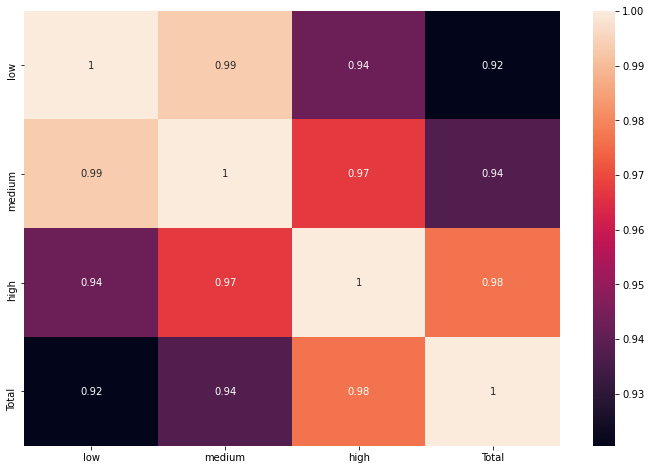

In [174]:
#correlation between income and EV stations
plt.figure(figsize = (12, 8))

sns.heatmap(combine[["low", "medium", "high", "Total"]].corr(), annot = True)

In [175]:
#scatterplot income levels and total EV stations
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,8))

#fig.suptitle('Scatter diagram showing the relationship between low, medum and high income earners and Total EV stations')
#ax2.scatter(combine["medium"], combine["Total"],plt.xlabel('medium income group'), plt.ylabel('Total EV stations'))

#ax3.scatter(combine["high"], combine["Total"], plt.xlabel('high income group'), plt.ylabel('Total EV stations'))

#ax4.scatter(combine["high"], combine["Total"],  plt.xlabel('high income group'), plt.ylabel('Total EV stations'))

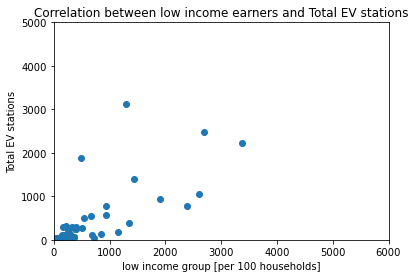

In [176]:
plt.scatter(x = combine["low"]/100, y = combine["Total"])
plt.xlabel('low income group [per 100 households]')
plt.ylabel('Total EV stations')
plt.title('Correlation between low income earners and Total EV stations')
plt.ylim(0, 5000)
plt.xlim(0,6000)
plt.show()       



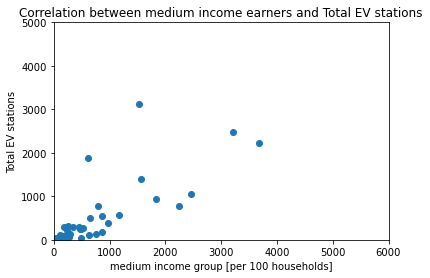

In [177]:
plt.scatter(x = combine["medium"]/100, y = combine["Total"])
plt.xlabel('medium income group [per 100 households]')
plt.ylabel('Total EV stations')
plt.title('Correlation between medium income earners and Total EV stations')
plt.ylim(0, 5000)
plt.xlim(0,6000)
plt.show()

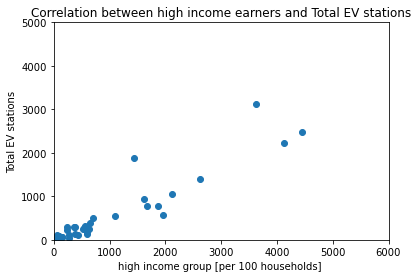

In [178]:
plt.scatter(x = combine["high"]/100, y = combine["Total"])
plt.xlabel('high income group [per 100 households] ')
plt.ylabel('Total EV stations')
plt.title('Correlation between high income earners and Total EV stations')
plt.ylim(0, 5000)
plt.xlim(0,6000)
plt.show()

In [179]:
#income regression - Model 2

We calculate average household income from our dataFirst step, we calculate average income of each income bracket. Then, we multiply the result by the number of households in that bracket. Finally, we aggregate the total figure of each county and divie by the total number of households in each county.

In [180]:
combine["less_than_10k"] = ((10000 + 5000)/2) * combine["SE_A14001_002"]

In [181]:
combine["10k-15k"] = ((14999 + 10000)/2) * combine["SE_A14001_003"]

In [182]:
combine["15k-20k"] = ((19999 + 15000)/2) * combine["SE_A14001_004"]

In [183]:
combine["20k-25k"] = ((24999 + 20000)/2) * combine["SE_A14001_005"]

In [184]:
combine["25k-30k"] = ((29999 + 25000)/2) * combine["SE_A14001_006"]

In [185]:
combine["30k-35k"] = ((34999 + 30000)/2) * combine["SE_A14001_007"]

In [186]:
combine["35k-40k"] = ((39999 + 35000)/2) * combine["SE_A14001_008"]

In [187]:
combine["40k-45k"] = ((44999 + 40000)/2) * combine["SE_A14001_009"]

In [188]:
combine["45k-50k"] = ((49999 + 45000)/2) * combine["SE_A14001_010"]

In [189]:
combine["50k-60k"] = ((59999 + 50000)/2) * combine["SE_A14001_011"]

In [190]:
combine["60k-75k"] = ((74999 + 60000)/2) * combine["SE_A14001_012"]

In [191]:
combine["75k-100k"] = ((99999 + 75000)/2) * combine["SE_A14001_013"]

In [192]:
combine["100k-125k"] = ((124999 + 100000)/2) * combine["SE_A14001_014"]

In [193]:
combine["125k-150k"] = ((149999 + 125000)/2) * combine["SE_A14001_015"]

In [194]:
combine["150k-200k"] = ((199999 + 150000)/2) * combine["SE_A14001_016"]

In [195]:
combine["200k and more"] = ((400000 - 200000)/2) * combine["SE_A14001_017"]


In [196]:
avg_income = combine[["Total", "pop", "SE_A14001_001"]]

In [197]:
 #combine[["Total", "pop", "SE_A14001_001"]]

In [198]:
#combine["SE_A14001_001"]

In [199]:
combine#.columns

,NAMELSAD,Total,pop,SE_A14001_017,SE_A14001_016,SE_A14001_015,SE_A14001_014,SE_A14001_013,SE_A14001_012,SE_A14001_011,...,35k-40k,40k-45k,45k-50k,50k-60k,60k-75k,75k-100k,100k-125k,125k-150k,150k-200k,200k and more
0,Alameda County,1391.0,1483849,93129.0,65633.0,46343.0,56631.0,65209.0,44002.0,32071.0,...,5.953046e+08,6.425499e+08,7.455522e+08,1.763889e+09,2.970113e+09,5.705755e+09,6.370959e+09,6.372139e+09,1.148574e+10,9.312900e+09
1,Alpine County,10.0,5727,100.0,91.0,110.0,169.0,182.0,171.0,135.0,...,1.012486e+06,4.632446e+06,3.372464e+06,7.424932e+06,1.154241e+07,1.592491e+07,1.901242e+07,1.512494e+07,1.592495e+07,1.000000e+07
2,Amador County,21.0,38211,725.0,591.0,869.0,1286.0,1963.0,1766.0,986.0,...,2.429968e+07,2.358722e+07,2.422474e+07,5.422951e+07,1.192041e+08,1.717615e+08,1.446744e+08,1.194871e+08,1.034247e+08,7.250000e+07
3,Butte County,58.0,187752,2868.0,3128.0,3146.0,5155.0,7527.0,6374.0,5486.0,...,1.413731e+08,1.423308e+08,1.671982e+08,3.017273e+08,4.302418e+08,6.586087e+08,5.799349e+08,4.325734e+08,5.473984e+08,2.868000e+08
4,Calaveras County,7.0,41036,746.0,1310.0,1065.0,1265.0,2086.0,1309.0,1373.0,...,2.812462e+07,3.574208e+07,3.391464e+07,7.551431e+07,8.835685e+07,1.825240e+08,1.423119e+08,1.464370e+08,2.292493e+08,7.460000e+07
5,Colusa County,24.0,21608,308.0,398.0,270.0,505.0,1068.0,893.0,495.0,...,1.128735e+07,1.682980e+07,1.405985e+07,2.722475e+07,6.027705e+07,9.344947e+07,5.681225e+07,3.712486e+07,6.964980e+07,3.080000e+07
6,Contra Costa County,569.0,1085278,72304.0,45515.0,34135.0,43220.0,50051.0,32802.0,22856.0,...,4.280568e+08,5.128415e+08,5.692340e+08,1.257069e+09,2.214119e+09,4.379437e+09,4.862228e+09,4.693545e+09,7.965102e+09,7.230400e+09
7,Del Norte County,28.0,28596,316.0,281.0,256.0,678.0,1140.0,1033.0,979.0,...,1.252483e+07,1.857228e+07,1.101988e+07,5.384451e+07,6.972698e+07,9.974943e+07,7.627466e+07,3.519987e+07,4.917486e+07,3.160000e+07
8,El Dorado County,119.0,180987,8571.0,6287.0,5158.0,7723.0,8949.0,6147.0,4481.0,...,8.977380e+07,8.814396e+07,1.123838e+08,2.464528e+08,4.149194e+08,7.830330e+08,8.688336e+08,7.092224e+08,1.100222e+09,8.571000e+08
9,Fresno County,375.0,907268,13284.0,15345.0,15113.0,22132.0,34156.0,29400.0,22662.0,...,4.765061e+08,6.076154e+08,5.156071e+08,1.246399e+09,1.984485e+09,2.988633e+09,2.489839e+09,2.078030e+09,2.685367e+09,1.328400e+09


In [200]:
#income average of each income bracket
avg_income["income_avg"] = combine[['less_than_10k',
       '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k', '35k-40k',
       '40k-45k', '45k-50k', '60k-75k', '75k-100k', '50k-60k', '100k-125k',
       '125k-150k', '150k-200k', '200k and more']].sum(axis = 1)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [201]:
#average income of each county from dividing the aggregated income average by the total number of households
avg_income["main_avg_income"] = (avg_income["income_avg"])/(combine["SE_A14001_001"])

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
avg_income["Density"] = pop_density["Density"]

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [222]:
#combined data for the regression
#avg_income.drop("dataset", axis = 1, inplace = True)

In [223]:
avg_income.dropna(inplace = True)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [224]:
#we regress average income on total EV stations
x = avg_income[["Density",
       "pop", "main_avg_income"]]

y = avg_income['Total']

In [225]:
# For our model we would split level1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [226]:
# Now we fit our model using linear regression
from sklearn.linear_model import LinearRegression
mod = LinearRegression()# Let's have a look at our model coefficient and intercept

mod.fit(x_train, y_train)

LinearRegression()

In [227]:
x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     215.3
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           5.22e-30
Time:                        21:48:16   Log-Likelihood:                -414.71
No. Observations:                  58   AIC:                             837.4
Df Residuals:                      54   BIC:                             845.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -975.8057    286.814     

In [228]:
#regressing total number of high income earners on total EV charging stations
x = combine[["pop",
       "high"]]

y = combine['Total']

In [229]:
# For our model we would split level1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [230]:
# Now we fit our model using linear regression
from sklearn.linear_model import LinearRegression
mod = LinearRegression()# Let's have a look at our model coefficient and intercept

mod.fit(x, y)

LinearRegression()

In [231]:
x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     565.5
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           2.10e-37
Time:                        21:48:19   Log-Likelihood:                -399.94
No. Observations:                  58   AIC:                             805.9
Df Residuals:                      55   BIC:                             812.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.1659     35.934     -1.396      0.1

# Model 3 - Location and Design 

Here we test if the time spent by users at a particular facility corresponds to the particular design at the specific facility

In [232]:
# Let us prepare data for our model 3
model_df = clean_df[["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count", "Facility Type"]]

In [233]:
# Create a function to give each facility type a time interval
def timespent(fac):
    short_time = ["SHOPPING_CENTER", "SHOPPING_MALL", "RESTAURANT"]
    medium_to_long_time = ["CAR_DEALER", "OFFICE_BLDG", "MUNI_GOV", "HOTELS", "UTILITY", "PARKING_LOT", "PARKING_GARAGE", "PAY_GARAGE","PAY_LOT", "SCHOOL" ]
    if fac in short_time:
        return "short_time_spent"
    elif fac in medium_to_long_time:
        return "medium_to_long_time_spent"

In [234]:
# Use the function to determine the time spent at each facility
model_df["Time Spent"] = model_df["Facility Type"].apply(timespent)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [235]:
model_df

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Facility Type,Time Spent
0,2.0,NaN,NaN,PAY_GARAGE,medium_to_long_time_spent
1,NaN,15.0,NaN,UTILITY,medium_to_long_time_spent
2,22.0,22.0,NaN,UTILITY,medium_to_long_time_spent
3,NaN,12.0,NaN,PARKING_GARAGE,medium_to_long_time_spent
4,NaN,239.0,NaN,UTILITY,medium_to_long_time_spent
...,...,...,...,...,...
6554,NaN,1.0,NaN,NaN,NaN
6555,NaN,2.0,NaN,NaN,NaN
6556,NaN,1.0,NaN,NaN,NaN
6557,NaN,12.0,NaN,NaN,NaN


In [236]:
# We need to create dummie variables for time spent 

dummie = pd.get_dummies(model_df["Time Spent"])
mod_df = pd.concat([dummie, model_df], axis = 1)
mod_df.head()


,medium_to_long_time_spent,short_time_spent,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Facility Type,Time Spent
0,1,0,2.0,NaN,NaN,PAY_GARAGE,medium_to_long_time_spent
1,1,0,NaN,15.0,NaN,UTILITY,medium_to_long_time_spent
2,1,0,22.0,22.0,NaN,UTILITY,medium_to_long_time_spent
3,1,0,NaN,12.0,NaN,PARKING_GARAGE,medium_to_long_time_spent
4,1,0,NaN,239.0,NaN,UTILITY,medium_to_long_time_spent


In [237]:
# Get EV level 1 data for our regression model
EV1 = mod_df[["short_time_spent", "medium_to_long_time_spent", "EV Level1 EVSE Num"]]
EV1.dropna(inplace =  True)   # we drop Na's because it is not important for our model
EV1.reset_index(drop = True, inplace = True)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [238]:
EV1

,short_time_spent,medium_to_long_time_spent,EV Level1 EVSE Num
0,0,1,2.0
1,0,1,22.0
2,0,0,1.0
3,0,1,12.0
4,0,0,2.0
...,...,...,...
164,0,0,1.0
165,0,0,1.0
166,0,0,12.0
167,0,0,1.0


In [239]:
 #Get x and y values
y = EV1["EV Level1 EVSE Num"]
x = EV1[["medium_to_long_time_spent"]] #Short_time_spent is dropped from the regression to serve as the base category

In [240]:
# For our model we would split EV1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [241]:
import statsmodels.api as sm

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     EV Level1 EVSE Num   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     22.53
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           4.42e-06
Time:                        21:48:25   Log-Likelihood:                -530.15
No. Observations:                 169   AIC:                             1064.
Df Residuals:                     167   BIC:                             1071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [242]:
from sklearn.linear_model import LinearRegression
mod1 = LinearRegression()
mod1.fit(x_train, y_train)

# model predictions
predictions = mod1.predict(x_test)

# Residual Histogram
#sns.distplot((y_test-predictions),bins=20);

In [243]:
#we check for absolute measure of fit for the regression. The RMSE result looks good

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.337454981992797
MSE: 14.231542331218202
RMSE: 3.772471647503557


In [244]:
# Get EV level 2 data for our regression model
EV2 = mod_df[["short_time_spent", "medium_to_long_time_spent", "EV Level2 EVSE Num"]]
EV2.dropna(inplace =  True)   # we drop Na's because it is not important for our model
EV2.reset_index(drop = True, inplace = True)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [245]:
# Get x and y values s
y = EV2[["EV Level2 EVSE Num"]]
x = EV2[["medium_to_long_time_spent"]] #Short_time_spent is dropped from the regression to serve as the base category

In [246]:
# For our model we would split EV1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [247]:
import statsmodels.api as sm

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     EV Level2 EVSE Num   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.913
Date:                Tue, 21 Jul 2020   Prob (F-statistic):            0.00284
Time:                        21:48:28   Log-Likelihood:                -20132.
No. Observations:                5947   AIC:                         4.027e+04
Df Residuals:                    5945   BIC:                         4.028e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [248]:
from sklearn.linear_model import LinearRegression
mod1 = LinearRegression()
mod1.fit(x_train, y_train)

# model predictions
predictions = mod1.predict(x_test)

# Residual Histogram
#sns.distplot((y_test-predictions),bins=20);

In [249]:
#we check for absolute measure of fit for the regression. The RMSE result looks good

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.8655772699762583
MSE: 34.8197802319988
RMSE: 5.900828775011083


In [250]:
# Get EV level 2 data for our regression model
EV3 = mod_df[["short_time_spent", "medium_to_long_time_spent", "EV DC Fast Count"]]
EV3.dropna(inplace =  True)   # we drop Na's because it is not important for our model
EV3.reset_index(drop = True, inplace = True)

C:\Users\Ifeanyi\Anaconda3\envs\My works\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
# Get x and y values s
y = EV3[["EV DC Fast Count"]]
x = EV3[["medium_to_long_time_spent"]] #Short_time_spent is dropped from the regression to serve as the base category

In [252]:
# For our model we would split EV1 data into training data and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101)

In [253]:
import statsmodels.api as sm

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       EV DC Fast Count   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     21.54
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           3.95e-06
Time:                        21:48:31   Log-Likelihood:                -2894.4
No. Observations:                 941   AIC:                             5793.
Df Residuals:                     939   BIC:                             5803.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [254]:
from sklearn.linear_model import LinearRegression
mod1 = LinearRegression()
mod1.fit(x_train, y_train)

# model predictions
predictions = mod1.predict(x_test)

# Residual Histogram
#sns.distplot((y_test-predictions),bins=20);

In [255]:
#we check for absolute measure of fit for the regression. The RMSE result looks good

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.2979172898283973
MSE: 25.85395812902504
RMSE: 5.084678763601988


From the analysis, it seems that facilities where users spend medium to long time is positively correlated to EV level 1 and EV level 2 chargers, but negatively correlated with DC fast chargers. The result answers our research question, Location is a major determinant of EV charging design.

# Cluster Analysis

In [397]:
#Elbow method minimizing the Within-cluster Sum of Squares (WCSS(Sum_of_squared_distances)) for average income
from sklearn.cluster import KMeans

Sum_of_squared_distances=[]
K=range(1,30)

for k in K:
    km=KMeans(n_clusters=k)
    km=km.fit(avg_income[['Total','main_avg_income']])
    Sum_of_squared_distances.append(km.inertia_)

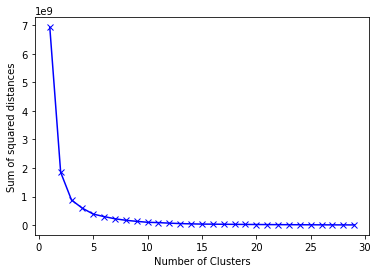

In [415]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method for optimal number of clusters')
#plt.savefig('Elbow Model2.png', dpi=300)
plt.show()

In [399]:
#Using K-Mean with optimal number of clusters k = 3 (elbow) 
km4=KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
km4=km4.fit(avg_income[['Total','main_avg_income']])
print(km4.labels_)

[1 2 2 0 2 2 1 0 1 0 0 0 0 0 0 2 0 2 2 0 1 0 0 0 0 2 2 1 2 1 1 0 2 2 1 2 1
 1 2 2 1 2 1 1 0 0 0 1 1 2 2 0 0 0 2 1 2 0]


In [400]:
#How many observations are in each cluster
#print(km4.labels_)
#result=km4.labels_
#result=pd.DataFrame(result, columns=['cluster'])
#result.groupby('cluster').size()

In [401]:
# Dictionary displaying the counties belonging to each cluster
#mydict = {i: np.where(km4.labels_ == i)[0] for i in range(km4.n_clusters)}
#mydict

In [402]:
#Converting the dictionary into a list

#dictlist = []
#for key, value in mydict.items():
#    temp = [key,value]
#    dictlist.append(temp)
#dictlist

In [403]:
#The centroid of cluster
centroids=km4.cluster_centers_
centroids=pd.DataFrame(centroids, columns=['Centroid Total','main_avg_income'])
centroids.head()

,Centroid Total,main_avg_income
0,54.500,58683.672875
1,929.625,84241.632853
2,582.550,69274.980796


In [404]:
# colored clusters k=4
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(avg_income[['Total','main_avg_income']])
y_kmeans = kmeans.predict(avg_income[['Total','main_avg_income']])
y_kmeans

array([1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0,
       0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0])

[[5.45000000e+01 5.86836729e+04]
 [9.29625000e+02 8.42416329e+04]
 [5.82550000e+02 6.92749808e+04]]


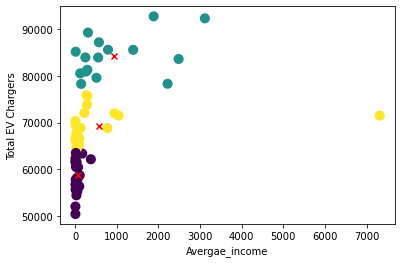

In [416]:
#scatter diagram showing the clusters with centroids
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(avg_income[['Total','main_avg_income']])
print(kmeans_model.cluster_centers_)
centers=np.array(kmeans_model.cluster_centers_)

plt.scatter(avg_income["Total"], avg_income["main_avg_income"], c=y_kmeans, s=50, cmap='viridis', linewidths=3)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
#plt.title('Scatter Diagram')
plt.xlabel('Avergae_income')
plt.ylabel('Total EV Chargers')
#plt.savefig('k4 c Model2.png', dpi=300)
plt.show()

[[5.45000000e+01 5.86836729e+04]
 [9.29625000e+02 8.42416329e+04]
 [5.82550000e+02 6.92749808e+04]]


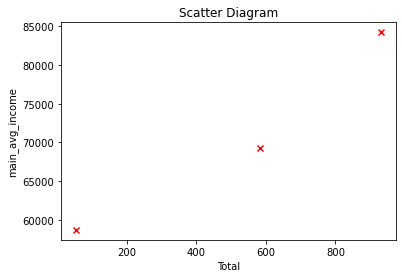

In [406]:
# plotting only centroids k=4

kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(avg_income[['Total','main_avg_income']])
print(kmeans_model.cluster_centers_)
centers=np.array(kmeans_model.cluster_centers_)

plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.title('Scatter Diagram')
plt.ylabel('main_avg_income')
plt.xlabel('Total')
#plt.savefig('Centroids k4 Model2.png', dpi=300)
plt.show()

In [407]:
pop_cluster = pop_density.drop([pop_density.index[37], pop_density.index[18], pop_density.index[29]])

In [408]:
#pop_cluster.reset_index(inplace = True)
#pop_cluster.drop("index", axis =1, inplace = True)

In [409]:
#pop_cluster


In [410]:
#Elbow method minimizing the Within-cluster Sum of Squares (WCSS(Sum_of_squared_distances)) for population density
from sklearn.cluster import KMeans

Sum_of_squared_distances1=[]
K=range(1,30)

for k in K:
    km1=KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km1=km1.fit(pop_cluster[['Total EV','Density']])
    Sum_of_squared_distances1.append(km1.inertia_)

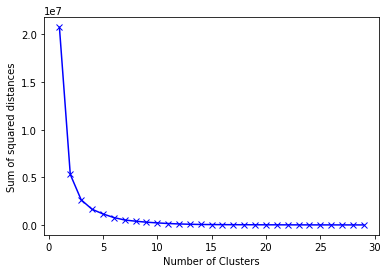

In [411]:
#Plotting the Elbow Curve by k number of clusters

plt.plot(K, Sum_of_squared_distances1, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method for optimal number of clusters')
plt.savefig('Elbow Model1.png', dpi=300)
plt.show()

In [412]:
km_4=KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
km_4=km_4.fit(pop_cluster[['Total EV','Density']])
print(km_4.labels_)

[2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 1 0 0
 1 0 1 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0]


In [413]:
#The centroids of the clusters
centroids1=km_4.cluster_centers_
centroids1=pd.DataFrame(centroids1, columns=['Centroid Total EV','Centroid Area Desnity'])
centroids1

,Centroid Total EV,Centroid Area Desnity
0,92.088889,44.663413
1,2405.333333,473.572806
2,825.571429,338.008620


In [414]:
#centroids1.drop["Centroid Area Desnity"].drop ([centroids1.index[2], pop_density.index[29]])

#centroids1.drop([centroids1.index[2]])

[[  92.08888889   44.6634127 ]
 [2405.33333333  473.57280595]
 [ 825.57142857  338.0086205 ]]


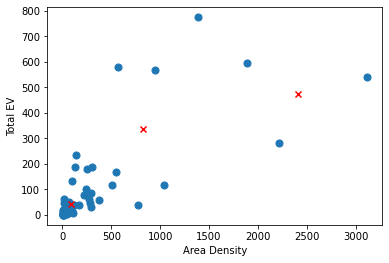

In [417]:
#scatterplot diagram showing the clusters with centroids
kmeans_model1 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pop_cluster[['Total EV','Density']])
print(kmeans_model1.cluster_centers_)
centers1=np.array(kmeans_model1.cluster_centers_)

plt.scatter(pop_cluster["Total EV"], pop_cluster["Density"], s=50, cmap='viridis')
plt.scatter(centers1[:,0], centers1[:,1], marker="x", color='r', label=y_kmeans)
#plt.title('Scatter Diagram')
plt.xlabel('Area Density')
plt.ylabel('Total EV')
plt.savefig('k4 c Model1.png', dpi=300)
plt.show()

[[ 190.82692308   84.15219068]
 [3402.8         765.48697411]
 [ 787.         6629.84187805]]


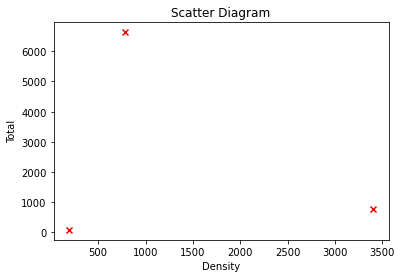

In [530]:
# plotting only centroids k=4

kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(avg_income[['Total','Density']])
print(kmeans_model.cluster_centers_)
centers=np.array(kmeans_model.cluster_centers_)

plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.title('Scatter Diagram')
plt.xlabel('Density')
plt.ylabel('Total')
#plt.savefig('Centroids k4 Model2.png', dpi=300)
plt.show()

In [ ]:
#Hierarchical clustering - dendrograms

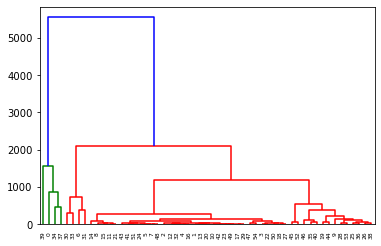

In [531]:
#Dendogram for Population density and Total EV stations
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(pop_cluster[['Density', 'Total EV']], method='ward'))
plt.savefig('Dendrogram Model2.png', dpi=300)

In [512]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
fcluster(linkage(avg_income, method='complete'), 4)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

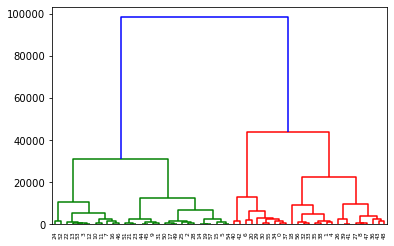

In [532]:
#Dendogram showing average income and Total EV stations
dendrogram = sch.dendrogram(sch.linkage(avg_income[['main_avg_income', 'Total']], method='ward'))
#plt.savefig('Dendrogram Model1.png', dpi=300)

To conclude, the outcome of both clustering techniques are consistent with my regression results and answers my research question. However, for the Dendogram, the outliers in model 1 like San Francisco and Los Angeles, makes the clstering a bit skewed. 